In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sn
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
import copy
import yaml

In [2]:
class Run:
    def __init__(self, checkpoints, compare_checkpoints, root_folder="output/", name="NotGiven", columns=[]):            
        
        dict_list=[]
        for dataset in checkpoints.keys():
            for model in checkpoints[dataset].keys():
                for idx, checkpoint in enumerate(checkpoints[dataset][model]):     
                    # print(dataset,model,checkpoint)
                    # print(os.path.join(root_folder,dataset,model,f"version_{checkpoint}"))
                    learning_rate,max_epochs,weight_decay,optimizer=self.get_hyperparameters(os.path.join(root_folder,dataset,model,f"version_{checkpoint}"))
                    acc,loss = self.get_metrics(os.path.join(root_folder,dataset,model,f"version_{checkpoint}"))
                    dict_list.append({
                        "model":model,
                        "dataset":dataset,
                        "checkpoint":checkpoint if len(columns)==0 else columns[idx],
                        "type":"MinimizedDataset",
                        "accuracy":float(acc),
                        "loss":float(loss),
                        "learning_rate":learning_rate,
                        "max_epochs":max_epochs,
                        "weight_decay": weight_decay,
                        "optimizer": optimizer
                    })
                    
        for dataset in compare_checkpoints.keys():            
            for model in compare_checkpoints[dataset].keys():                  
                for idx,checkpoint in enumerate(compare_checkpoints[dataset][model]):
                    learning_rate,max_epochs,weight_decay,optimizer=self.get_hyperparameters(os.path.join(root_folder,dataset,model,f"version_{checkpoint}"))
                    acc,loss = self.get_metrics(os.path.join(root_folder,dataset,model,f"version_{checkpoint}"))
                    dict_list.append({
                        "model":model,
                        "dataset":dataset,
                        "checkpoint":checkpoint if len(columns)==0 else columns[idx],
                        "type":"FullDataset",
                        "accuracy":float(acc),
                        "loss":float(loss),
                        "learning_rate":learning_rate,
                        "max_epochs":max_epochs,
                        "weight_decay": weight_decay,
                        "optimizer": optimizer
                    })
              
        self.run_df = pd.DataFrame.from_records(dict_list)
        self.name = name        
                    
        
                
    def get_metrics(self,root):    
        df_tmp = pd.read_csv(os.path.join(root,"metrics.csv"))
        acc=float(df_tmp[df_tmp['acc/val'] == df_tmp['acc/val'].max()]['acc/val'].values[0])
        loss = float(df_tmp[df_tmp['acc/val'] == df_tmp['acc/val'].max()]['loss/val'].values[0])
        return acc,loss
    
    def get_hyperparameters(self,root):
        with open(os.path.join(root,"hparams.yaml")) as stream:
            data_loaded = yaml.safe_load(stream)        
        learning_rate=float(data_loaded['hparams']['learning_rate'])
        max_epochs=int(data_loaded['hparams']['max_epochs'])
        weight_decay=float(data_loaded['hparams']['weight_decay'])
        optimizer=str(data_loaded['hparams']['optimizer'])
        return learning_rate,max_epochs,weight_decay,optimizer    
    
    def get_metrics_by_dataset(self,dataset):
        temp_df_metric_acc=self.run_df[(self.run_df['dataset']==dataset) & (self.run_df['type']=="MinimizedDataset")].set_index(['model','checkpoint'])['accuracy'].subtract(self.run_df[(self.run_df['dataset']==dataset) & (self.run_df['type']=="FullDataset")].set_index(['model','checkpoint'])['accuracy']).reset_index().pivot_table('accuracy','checkpoint','model')
        temp_df_metric_loss=self.run_df[(self.run_df['dataset']==dataset) & (self.run_df['type']=="MinimizedDataset")].set_index(['model','checkpoint'])['loss'].subtract(self.run_df[(self.run_df['dataset']==dataset) & (self.run_df['type']=="FullDataset")].set_index(['model','checkpoint'])['loss']).reset_index().pivot_table('loss','checkpoint','model')
        temp_df_acc=self.run_df[(self.run_df['dataset']==dataset) & (self.run_df['type']=="MinimizedDataset")].set_index(['model','checkpoint'])['accuracy'].reset_index().pivot_table('accuracy','checkpoint','model')
        temp_df_loss=self.run_df[(self.run_df['dataset']==dataset) & (self.run_df['type']=="MinimizedDataset")].set_index(['model','checkpoint'])['loss'].reset_index().pivot_table('loss','checkpoint','model')
        
        return temp_df_acc,temp_df_loss,temp_df_metric_acc,temp_df_metric_loss
        

In [3]:
def heatmap(runs, by="model"):         
    rows={}
    names=[]
    rows['acc']=[]
    rows['loss']=[]
    rows['acc_metric']=[]
    rows['loss_metric']=[]
    for run in runs:
        acc,loss,acc_m,loss_m=run.get_metrics_by_dataset("cifar10")
        names.append(run.name)
        if by == "model":
            rows['acc'].append(acc.mean())
            rows['loss'].append(loss.mean())
            rows['acc_metric'].append(acc_m.mean())
            rows['loss_metric'].append(loss_m.mean())
        if by == "checkpoint":
            rows['acc'].append(acc.T.mean())
            rows['loss'].append(loss.T.mean())
            rows['acc_metric'].append(acc_m.T.mean())
            rows['loss_metric'].append(loss_m.T.mean())        
    
    def heatmap_func(metric, heat_range=()):
        use_df=None
        if metric == "acc":
            use_df=pd.DataFrame.from_records(rows["acc"])            
        if metric == "loss":
            use_df=pd.DataFrame.from_records(rows["loss"]) 
        if metric == "acc_metric":
            use_df=pd.DataFrame.from_records(rows["acc_metric"]) 
        if metric == "loss_metric":
            use_df=pd.DataFrame.from_records(rows["loss_metric"])   
        # use_df['average']=use_df.mean(numeric_only=True, axis=1)
        plt.figure(figsize = (20,7))
        if heat_range!=():
            sn.heatmap(use_df, annot=True, vmin=heat_range[0], vmax=heat_range[1],fmt='.3g',yticklabels=names)
        else:
            sn.heatmap(use_df, annot=True,fmt='.3g',yticklabels=names)
            
    return heatmap_func    

In [4]:
def range_version(start,end):
    return list(range(start,end+1))

In [5]:
def generate_simple_runs(checkpoints,compare_checkpoint,root_folder,models, dataset,checkpoint_names):
    runs=[]
    
            
    for name, checkpoint in checkpoints.items():
        run_config=dict()
        run_config_compare=dict()
        run_config[dataset]=dict()
        run_config_compare[dataset]=dict()
        for model in models:
            run_config[dataset][model]=checkpoint
            run_config_compare[dataset][model]=[compare_checkpoint]*len(checkpoint)
        # print(run_config)
        runs.append(Run(run_config,run_config_compare,root_folder,columns=checkpoint_names,name=name))
                    
    return runs
            
        

In [6]:
%%html
<style>
table {margin-left: 0 !important;}
</style>

| RUN | batchsize | learning_rate | max_epochs | opimizer | weight_decay |
|---|---|---|---|---|---|
| 3 | 512 | 1e-5 | 10 | sgd | 0.01 |
| 4 | 512 | 1e-3 | 10 | sgd | 0.01 |
| 5 | 128 | 1e-3 | 10 | sgd | 0.01 |
| 6 | 256 | 1e-2 | 10 | sgd | 0.01 |
| 7 | 128 | 1e-2 | 10 | sgd | 0.01 |
| 8 | 128 | 1e-3 | 20 | sgd | 0.01 |
| 9 | 512 | 1e-3 | 10 | adam | 0.01 |
| 10 | 256 | 1e-3 | 20 | adam | 0.01 |
| 11 | 512 | 1e-3 | 30 | adam | 0.01 |
| 12 | 512 | 1e-5 | 15 | sgd | 0.01 |
| 13 | 128 | 1e-5 | 15 | sgd | 0.01 |
| 14 | 128 | 1e-4 | 15 | sgd | 0.01 |
| 15 | 64 | 1e-4 | 15 | sgd | 0.01 |
| 16 | 32 | 1e-4 | 20 | sgd | 0.01 |
| 17 | 64 | 1e-3 | 20 | sgd | 0.01 |
| 18 | 128 | 1e-5 | 20 | adam | 0.01 |
| 19 | 512 | 1e-6 | 20 | adam | 0.01 |
| 20 | 64 | 1e-4 | 20 | adam | 0.01 |
| 21 | 256 | 1e-4 | 20 | adam | 0.01 |

In [7]:
checkpoints={
    f"Run 3": range_version(15,21),
    f"Run 4": range_version(22,28),
    f"Run 5": range_version(29,35),    
    f"Run 6": range_version(36,42),
    f"Run 7": range_version(43,49),
    f"Run 8": range_version(50,56),
    f"Run 9": range_version(57,63),
    f"Run 10": range_version(64,70),
    f"Run 11": range_version(71,77),
    f"Run 12": range_version(78,84),
    f"Run 13": range_version(85,91),
    f"Run 14": range_version(92,98),
    f"Run 15": range_version(99,105),
    f"Run 16": range_version(106,112),
    f"Run 17": range_version(113,119),
    f"Run 18": range_version(120,126),
    f"Run 19": range_version(127,133),
    f"Run 20": range_version(134,140),
    f"Run 21": range_version(141,147),
    
}

In [8]:
checkpoint_names=[
    "cifar10_model",
    "cifar100_model",
    "grocerystore_model",
    "histaerial25x25",
    "histaerial50x50",
    "svhn_model",
    "tinyimagenet_model"
]

runs=generate_simple_runs(checkpoints,0,"../../../output_hyperparameters/",["lowres_resnet9","lowres_resnet50","lowres_densenet121","lowres_vgg16_bn"],"cifar10",checkpoint_names)

In [9]:
for ir, run in enumerate(runs):
    p_df=pd.concat([run.run_df[run.run_df['type']=='FullDataset'][['checkpoint','model','accuracy','loss']].set_index(['checkpoint','model']).sort_values(by=['checkpoint','model']),
               run.run_df[run.run_df['type']=='MinimizedDataset'][['checkpoint','model','accuracy','loss']].set_index(['checkpoint','model']).sort_values(by=['checkpoint','model'])], axis=1,)
    # print(p_df)
    p_df.to_csv(f"../../../cache/experiment_run{ir}.csv")

In [10]:
heatmap3_21_model=heatmap(runs,by="model")

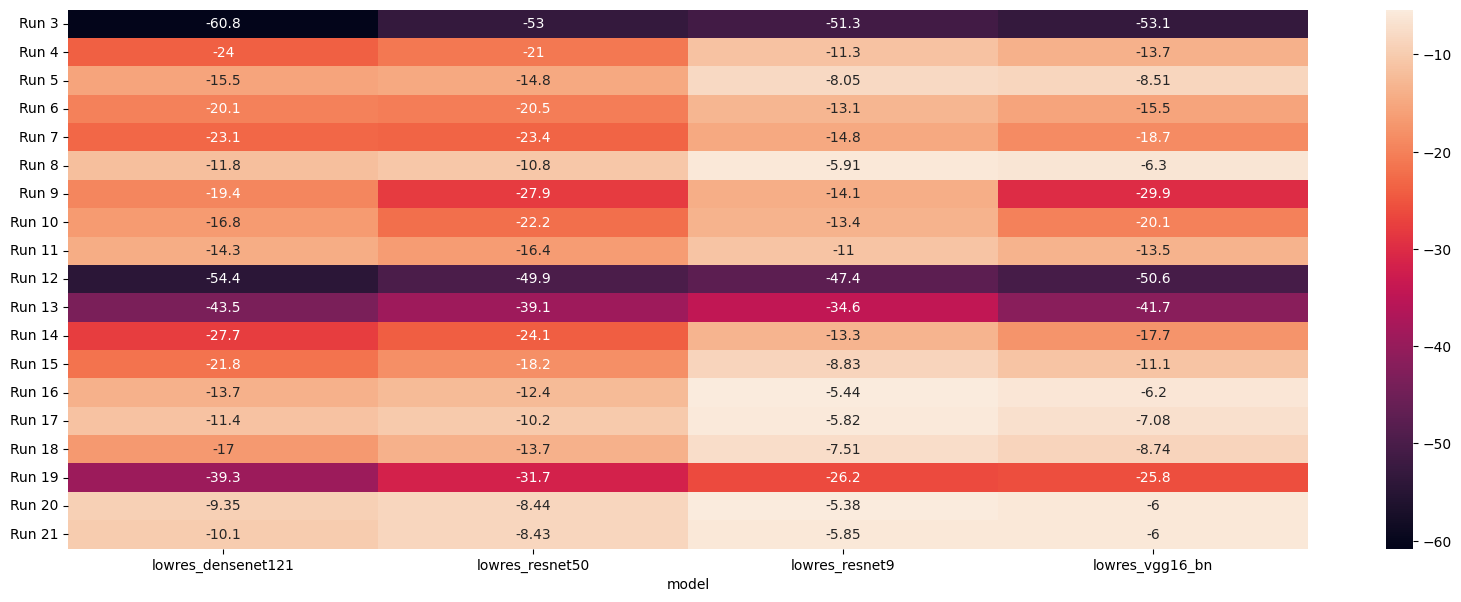

In [11]:
heatmap3_21_model("acc_metric")

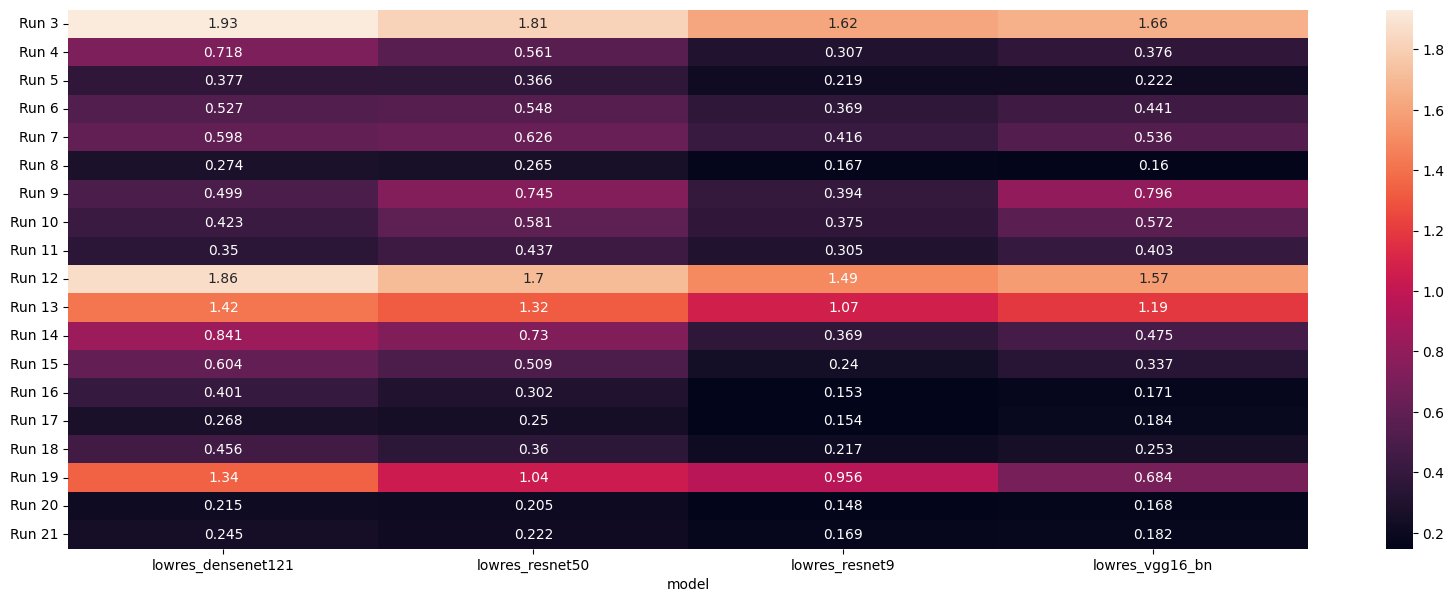

In [12]:
heatmap3_21_model("loss_metric")

In [13]:
heatmap3_21_checkpoint=heatmap(runs,by="checkpoint")

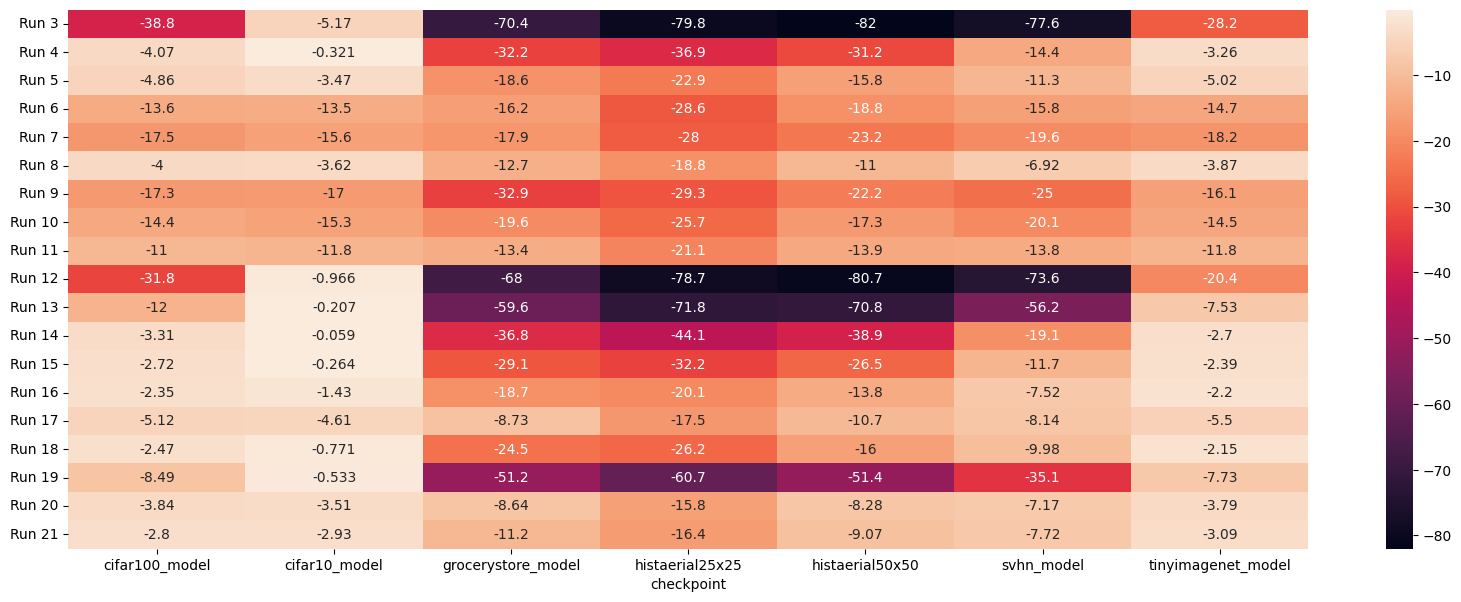

In [14]:
heatmap3_21_checkpoint("acc_metric")

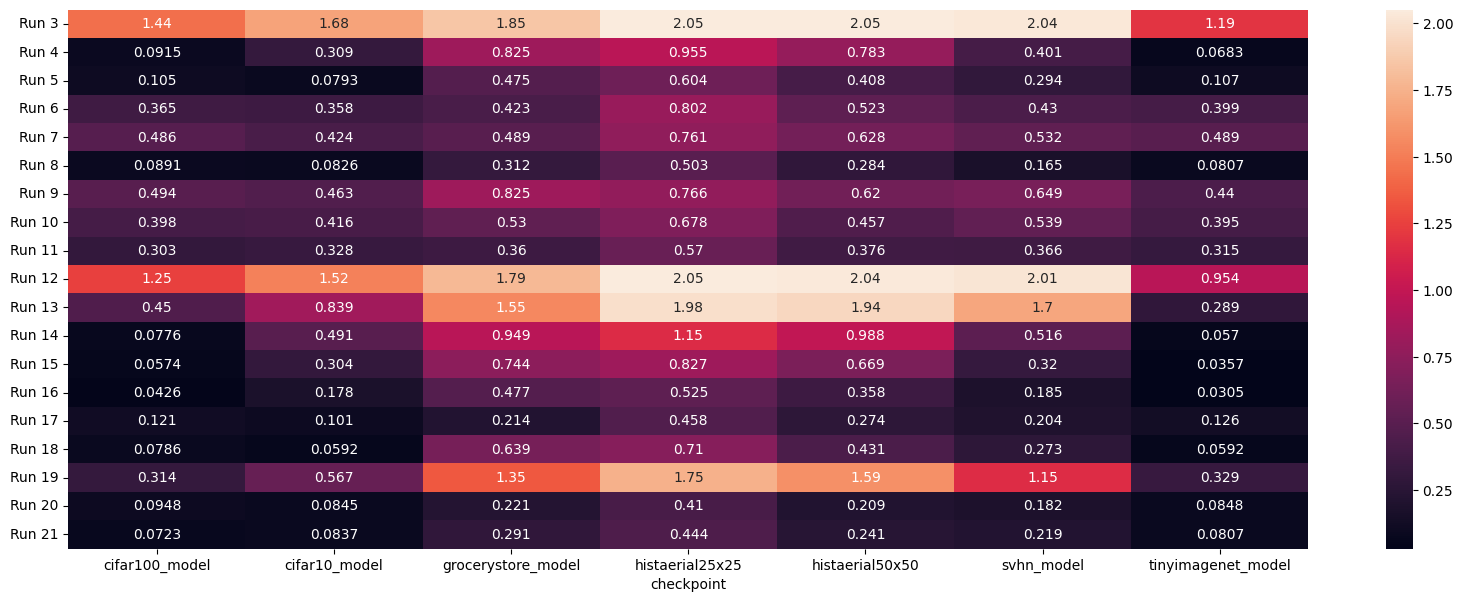

In [15]:
heatmap3_21_checkpoint("loss_metric")

In [16]:
old_versions=[[101,121,390,268,77],
[32,134,129,96,85],
[49,104,43,176,67],
[147,74,89,197,145]]

run_1_checkpoints={
    "cifar10": {
        "lowres_resnet9":[1,2,3,4,5],
        "lowres_resnet50":[1,2,3,4,5],
        "lowres_densenet121":[1,2,3,4,5],
        "lowres_vgg16_bn":[1,2,3,4,5],
               }    
}
run_1_compare_checkpoints={
    "cifar10": {
        "lowres_resnet9":[0,0,0,0,0],
        "lowres_resnet50":[0,0,0,0,0],
        "lowres_densenet121":[0,0,0,0,0],
        "lowres_vgg16_bn":[0,0,0,0,0],
               } 
}

old_versions=[[193,272,188,592,421],
[75,111,165,401,433],
[141,123,292,267,497],
[282,143,542,490,710]]

run_2_checkpoints={
    "cifar10": {
        "lowres_resnet9":[7,8,9,10,11],
        "lowres_resnet50":[7,8,9,10,11],
        "lowres_densenet121":[7,8,9,10,11],
        "lowres_vgg16_bn":[7,8,9,10,11],
               }    
}
run_2_compare_checkpoints={
    "cifar10": {
        "lowres_resnet9":[0,0,0,0,0],
        "lowres_resnet50":[0,0,0,0,0],
        "lowres_densenet121":[0,0,0,0,0],
        "lowres_vgg16_bn":[0,0,0,0,0],
               } 
}

run_3_checkpoints={
    "cifar10": {
        "lowres_resnet9":[7,8,9,10,11],
        "lowres_resnet50":[7,8,9,10,11],
        "lowres_densenet121":[7,8,9,10,11],
        "lowres_vgg16_bn":[7,8,9,10,11],
               }    
}
run_3_compare_checkpoints={
    "cifar10": {
        "lowres_resnet9":[6,6,6,6,6],
        "lowres_resnet50":[6,6,6,6,6],
        "lowres_densenet121":[6,6,6,6,6],
        "lowres_vgg16_bn":[6,6,6,6,6],
               } 
}
run_4_checkpoints={
    "cifar10": {
        "lowres_resnet9":[7,8,9,10,11],
        "lowres_resnet50":[7,8,9,10,11],
        "lowres_densenet121":[7,8,9,10,11],
        "lowres_vgg16_bn":[7,8,9,10,11],
               }    
}

run_4_compare_checkpoints={
    "cifar10": {
        "lowres_resnet9":[12,12,12,12,12],
        "lowres_resnet50":[12,12,12,12,12],
        "lowres_densenet121":[12,12,12,12,12],
        "lowres_vgg16_bn":[12,12,12,12,12],
               } 
}

checkpoint_names=[
    "cifar10_model",
    "cifar100_model",
    "grocerystore_model",
    "svhn_model",
    "tinyimagenet_model"
]

In [17]:
runs=[
    Run(run_1_checkpoints,run_1_compare_checkpoints,"../../../output_sweep/",columns=checkpoint_names,name="Run 1 - Normal Sweep Full Dataset"),
    Run(run_2_checkpoints,run_2_compare_checkpoints,"../../../output_sweep/",columns=checkpoint_names,name="Run 2 - Small Sweep Full Dataset"),
    Run(run_2_checkpoints,run_3_compare_checkpoints,"../../../output_sweep/",columns=checkpoint_names,name="Run 3 - Small Sweep Small Dataset"),
    Run(run_3_checkpoints,run_4_compare_checkpoints,"../../../output_sweep/",columns=checkpoint_names,name="Run 4 - Small Sweep Small Dataset with Checkpoints")
]

In [18]:
runs[0].run_df[runs[0].run_df['type']=='FullDataset'][['checkpoint','model','accuracy','loss']].set_index(['checkpoint','model']).sort_values(by=['checkpoint','model'])

accuracy      loss
checkpoint         model                                  
cifar100_model     lowres_densenet121  93.599762  0.274991
                   lowres_resnet50     93.149033  0.264779
                   lowres_resnet9      94.531250  0.185658
                   lowres_vgg16_bn     93.609772  0.240045
cifar10_model      lowres_densenet121  93.599762  0.274991
                   lowres_resnet50     93.149033  0.264779
                   lowres_resnet9      94.531250  0.185658
                   lowres_vgg16_bn     93.609772  0.240045
grocerystore_model lowres_densenet121  93.599762  0.274991
                   lowres_resnet50     93.149033  0.264779
                   lowres_resnet9      94.531250  0.185658
                   lowres_vgg16_bn     93.609772  0.240045
svhn_model         lowres_densenet121  93.599762  0.274991
                   lowres_resnet50     93.149033  0.264779
                   lowres_resnet9      94.531250  0.185658
                   lowres_vgg16_bn     93.609772  0.240045
tinyimagenet_model lowres_densenet121  93.599762  0.274991
                   lowres_resnet50     93.149033  0.264779
                   lowres_resnet9      94.531250  0.185658
                   lowres_vgg16_bn     93.609772  0.240045

In [19]:
for ir, run in enumerate(runs):
    p_df=pd.concat([run.run_df[run.run_df['type']=='FullDataset'][['checkpoint','model','accuracy','loss']].set_index(['checkpoint','model']).sort_values(by=['checkpoint','model']),
               run.run_df[run.run_df['type']=='MinimizedDataset'][['checkpoint','model','accuracy','loss','learning_rate','max_epochs','weight_decay','optimizer']].set_index(['checkpoint','model']).sort_values(by=['checkpoint','model'])], axis=1,)
    # print(p_df)
    p_df.to_csv(f"../../../cache/sweep_run{ir}.csv")

In [20]:
def bar_plot_simple(df,dataset="cifar10"):
    
    df_full=df[(df["dataset"]==dataset)&(df["type"]=="FullDataset")].drop(["dataset","type",'learning_rate','max_epochs','weight_decay','optimizer'],axis=1).set_index(['checkpoint'])
    df_minimized=df[(df["dataset"]==dataset)&(df["type"]=="MinimizedDataset")].drop(["dataset","type",'learning_rate','max_epochs','weight_decay','optimizer'],axis=1).set_index(['checkpoint'])
    
    df_full['accuracy_min']=df_minimized['accuracy']
    df_full['loss_min']=df_minimized['loss']
    df_full['accuracy_diff']=df_minimized['accuracy'].subtract(df_full['accuracy'])
    df_full['loss_diff']=df_minimized['loss'].subtract(df_full['loss'])    
    
    models=df_minimized["model"].unique()
    nrows=int(np.floor(np.sqrt(len(models))))
    ncols=int(len(models)/nrows)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 7))

    models=np.reshape(models,(nrows,ncols))

    sn.set_theme()
    
    # df_full[df_full["model"]==models[0,0]].rename(columns={'accuracy':'Ohne Pretraining','accuracy_min':"FineTuning",'accuracy_diff':'Differenz'})[['Ohne Pretraining','FineTuning','Differenz']].plot(ax=axes,rot=0,kind="bar",fontsize=18)
    
    for row in range(nrows):
        for col in range(ncols):
            # df2_full[df2_full["model"]==models[row,col]].rename(columns={'accuracy':'Pretraining','accuracy_diff':'FineTuning'})[['Pretraining','FineTuning']].plot(position=0,width=0.25,title=models[row,col],ax=axes[row][col],rot=0,kind="bar",stacked=True)
            df_full[df_full["model"]==models[row,col]].rename(columns={'accuracy':'Ohne Pretraining','accuracy_min':"FineTuning",'accuracy_diff':'Differenz'})[['Ohne Pretraining','FineTuning','Differenz']].plot(title=models[row,col],ax=axes[row][col],rot=0,kind="bar")
            
            # df_minimized[df_minimized["model"]==models[row,col]][['accuracy','accuracy_diff']].plot(position=1,width=0.1,title=models[row,col],ax=axes[row][col],rot=0,kind="bar",stacked=True)
            # df_minimized[df_minimized["model"]==models[row,col]][['accuracy','accuracy_diff']].plot(position=2,width=0.1,title=models[row,col],ax=axes[row][col],rot=0,kind="bar",stacked=True)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes[0][0].legend(by_label.values(), by_label.keys(),loc='lower right')
    axes[0][1].legend(by_label.values(), by_label.keys(),loc='lower right')
    axes[1][0].legend(by_label.values(), by_label.keys(),loc='lower right')
    axes[1][1].legend(by_label.values(), by_label.keys(),loc='lower right')
    # axes.suptitle('lowres_resnet9', fontsize=20)
    # axes.set_xlabel("Pretrained Models")
    # axes.set_ylabel("Accuracy in %")
    # params = {'legend.fontsize': 16,
    #       'figure.figsize': (15, 5),
    #      'axes.labelsize': 18,
    #      'axes.titlesize':20,   
    #      'axes.labelpad': 20,
    #      # 'xtick.labelsize':18,
    #      # 'ytick.labelsize':18
    #          }
    # pylab.rcParams.update(pylab.rcParamsDefault)
    # pylab.rcParams.update(params)
    # print(pylab.rcParams.keys())
    fig.tight_layout()
    # fig.suptitle('Lowres Resnet 9', fontsize=18)
    return fig

In [21]:
def create_plot_df(df,dataset="cifar10"):
    df_full=df[(df["dataset"]==dataset)&(df["type"]=="FullDataset")].drop(["dataset","type",'learning_rate','max_epochs','weight_decay','optimizer'],axis=1).set_index(['checkpoint'])
    df_minimized=df[(df["dataset"]==dataset)&(df["type"]=="MinimizedDataset")].drop(["dataset","type",'learning_rate','max_epochs','weight_decay','optimizer'],axis=1).set_index(['checkpoint'])
    
    df_full['accuracy_min']=df_minimized['accuracy']
    df_full['loss_min']=df_minimized['loss']
    df_full['accuracy_diff']=df_minimized['accuracy'].subtract(df_full['accuracy'])
    df_full['loss_diff']=df_minimized['loss'].subtract(df_full['loss'])  
    
    return df_full

def bar_plot(runs,dataset="cifar10"):    
    
    runs.reverse()
    
    models=runs[0].run_df["model"].unique()
    nrows=len(models)
    ncols=1    

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, len(models)*5))

    # models=np.reshape(models,(nrows,ncols))
    
    barWidth=0.05 
    center = 0.5

    sn.set_theme()
    
  
    if(nrows % 2 != 0):
        positions=[-len(runs)/2+p+1 for p in np.arange(nrows)]
    if(nrows % 2 == 0):
        nr=len(runs)+1
        positions=[-nr/2+p+1 for p in np.arange(nr)]
        middle=int(np.floor(nr/2))        
        positions=list((np.array(positions[:middle])+0.5)) + list((np.array(positions[middle + 1:])-0.5))     
        
    
    for row in range(nrows):
        for run,position in zip(runs,positions):
            df_temp = create_plot_df(run.run_df,dataset)
            # df2_full[df2_full["model"]==models[row,col]].rename(columns={'accuracy':'Pretraining','accuracy_diff':'FineTuning'})[['Pretraining','FineTuning']].plot(position=0,width=0.25,title=models[row,col],ax=axes[row][col],rot=0,kind="bar",stacked=True)
            df_temp[df_temp["model"]==models[row]].rename(columns={'accuracy':'Ohne Pretraining','accuracy_min':"FineTuning",'accuracy_diff':'Differenz'})[['Ohne Pretraining','FineTuning','Differenz']] \
                .plot(title=models[row],ax=axes[row],rot=0,kind="bar",stacked=True,width=barWidth,position=position)            
            
            # df_minimized[df_minimized["model"]==models[row,col]][['accuracy','accuracy_diff']].plot(position=1,width=0.1,title=models[row,col],ax=axes[row][col],rot=0,kind="bar",stacked=True)
            # df_minimized[df_minimized["model"]==models[row,col]][['accuracy','accuracy_diff']].plot(position=2,width=0.1,title=models[row,col],ax=axes[row][col],rot=0,kind="bar",stacked=True)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    for idx,ax in enumerate(axes):
        axes[idx].legend(by_label.values(), by_label.keys(),loc='lower right')  
        for c in axes[idx].containers:
            # Optional: if the segment is small or 0, customize the labels
            labels = [f'{(v.get_height()/100):.2%}' for v in c]

            # remove the labels parameter if it's not needed for customized labels
            axes[idx].bar_label(c,labels=labels, label_type='center',rotation=90,fontsize=10,padding=10)
    
    # axes.suptitle('lowres_resnet9', fontsize=20)
    # axes.set_xlabel("Pretrained Models")
    # axes.set_ylabel("Accuracy in %")
    # params = {'legend.fontsize': 16,
    #       'figure.figsize': (15, 5),
    #      'axes.labelsize': 18,
    #      'axes.titlesize':20,   
    #      'axes.labelpad': 20,
    #      # 'xtick.labelsize':18,
    #      # 'ytick.labelsize':18
    #          }
    # pylab.rcParams.update(pylab.rcParamsDefault)
    # pylab.rcParams.update(params)
    # print(pylab.rcParams.keys())
    fig.tight_layout()
    # fig.suptitle('Lowres Resnet 9', fontsize=18)
    return fig

### Compare Small Dataset Finetuning to Full Dataset Finetuning

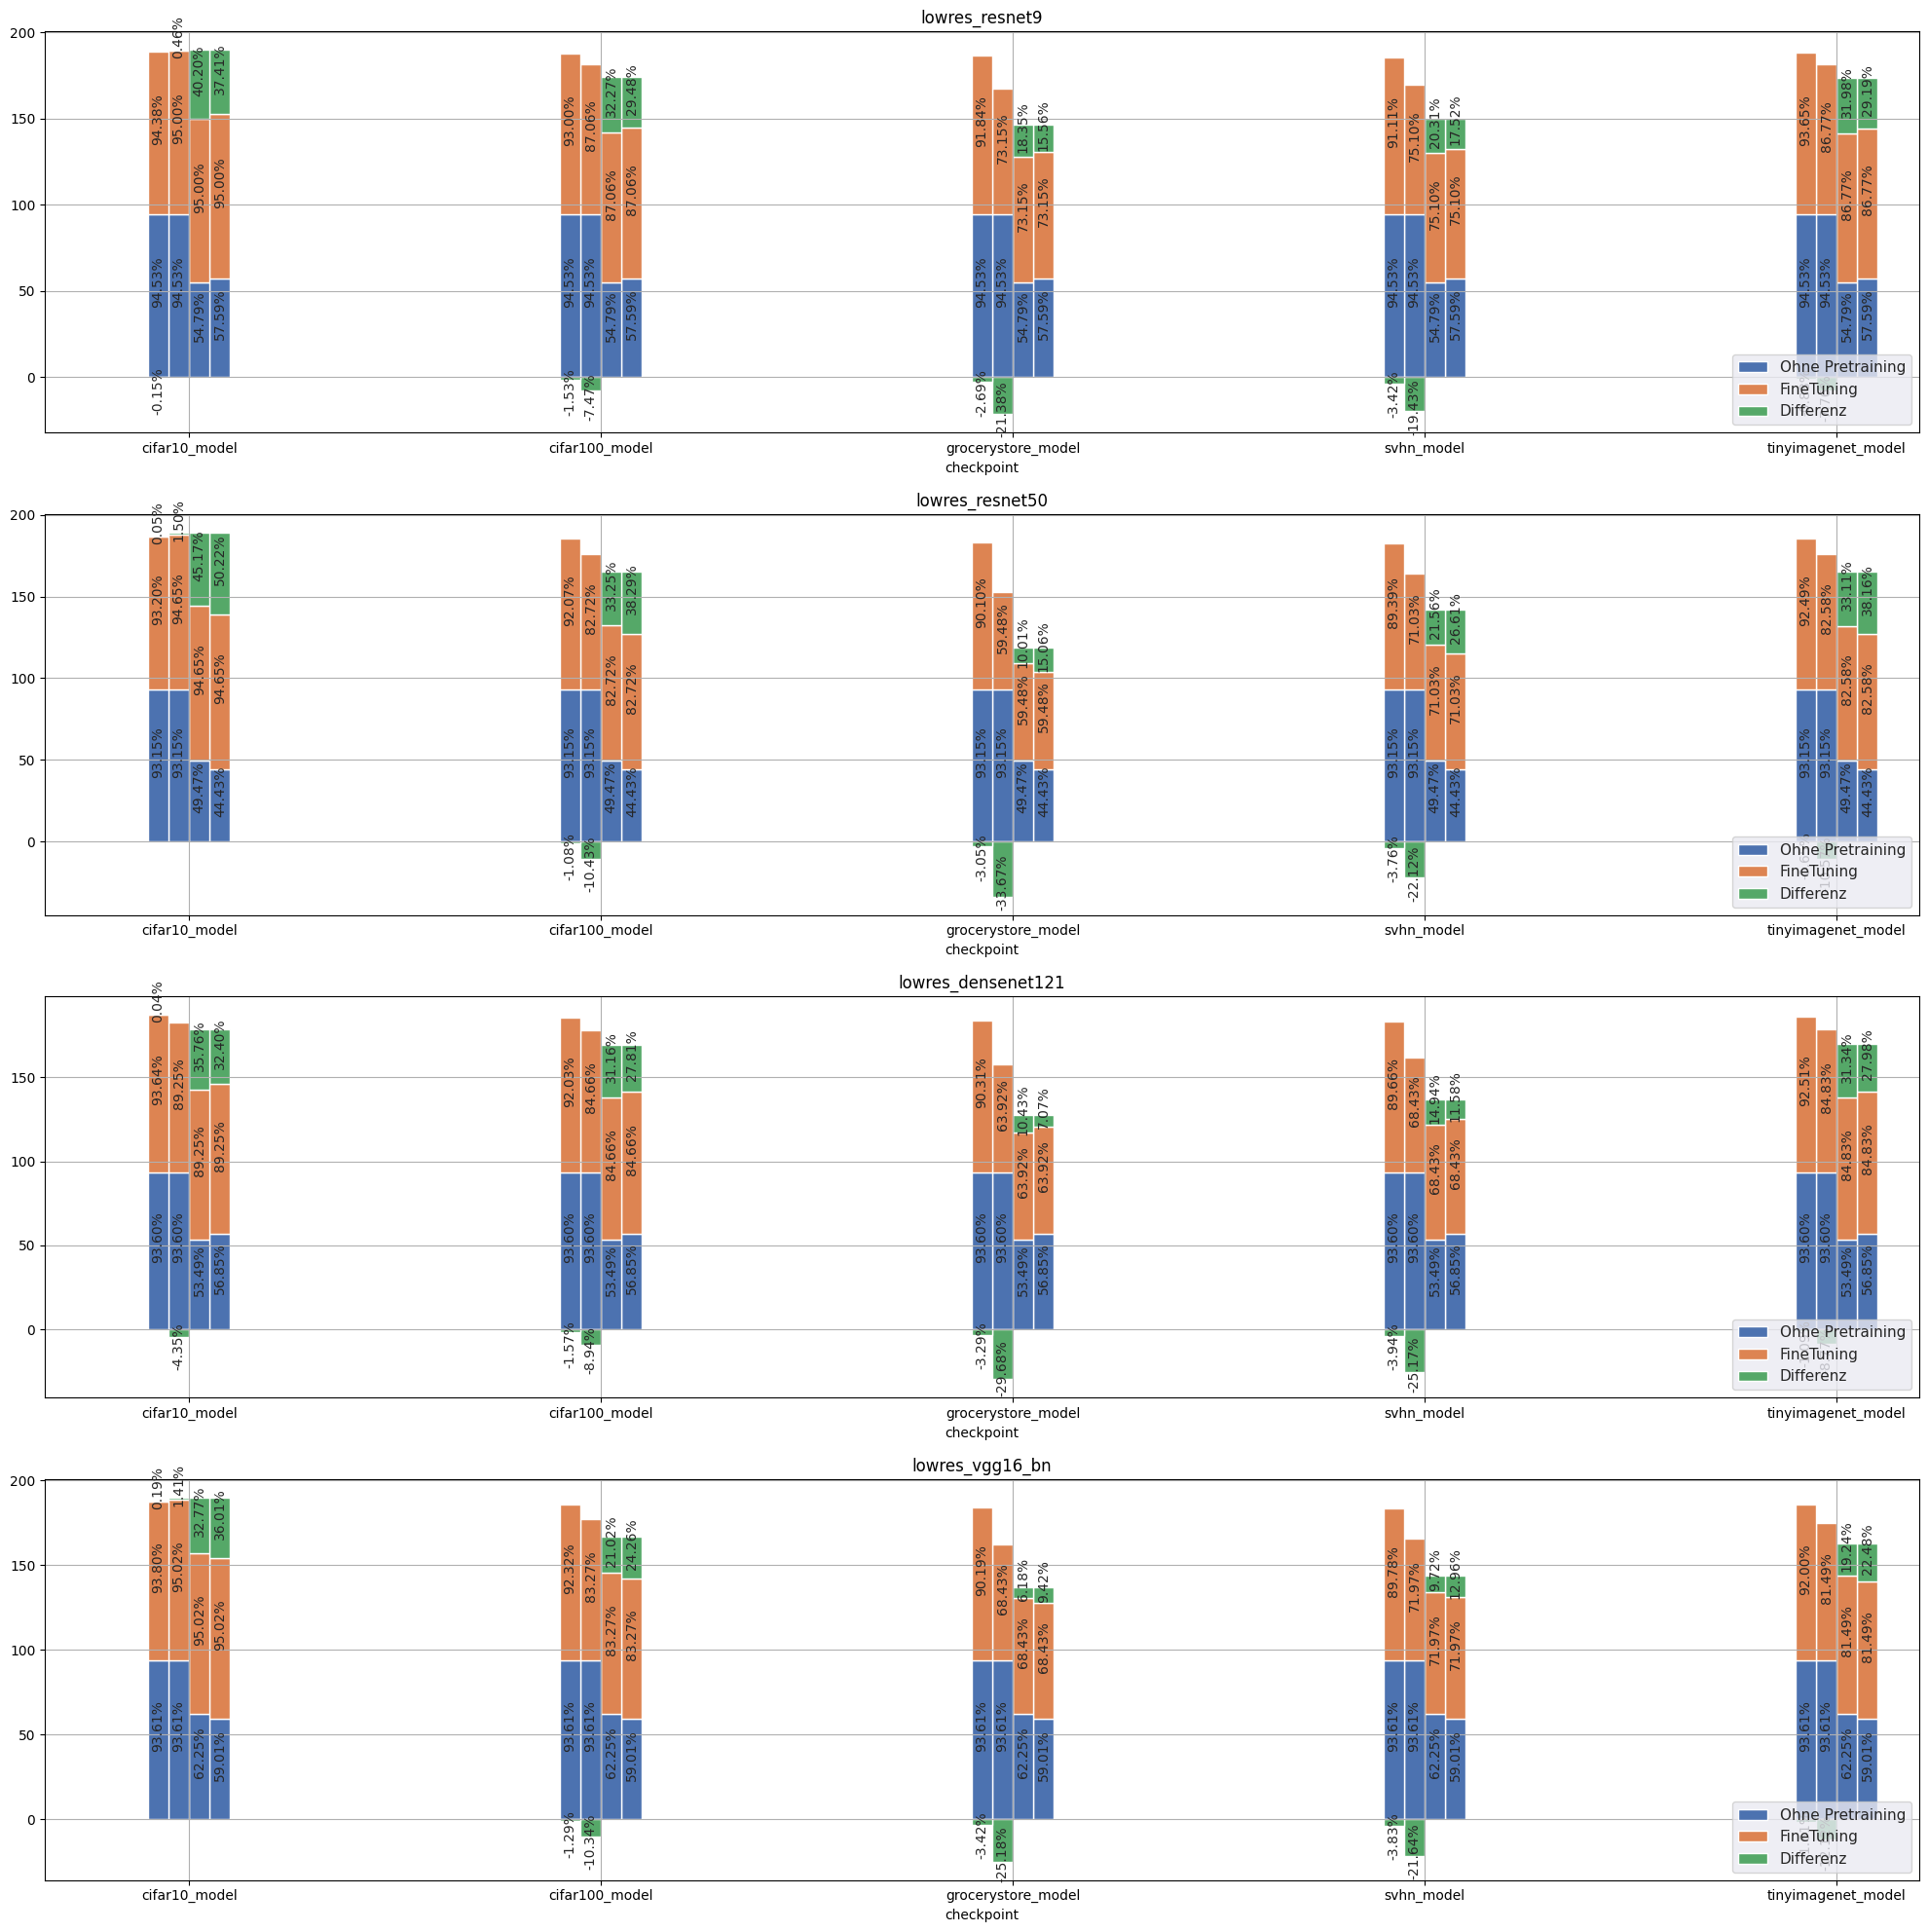

In [22]:
fig=bar_plot(runs)

## Hyperparameter Difference

### Initialisation

In [23]:
def plot_hyperparameters_difference(checkpoints,compare_checkpoints,output_path,dataset,models,checkpoint_names):
    hyperparameters = []

    for model in models:
        for idx,checkpoint in enumerate(checkpoints):
            with open(os.path.join(output_path,dataset,model,f"version_{checkpoint}","hparams.yaml")) as stream:
                data_loaded = yaml.safe_load(stream)
            hyperparameters.append({
                'model':model,
                'checkpoint':checkpoint_names[idx],
                'learning_rate':float(data_loaded['hparams']['learning_rate']),
                'max_epochs':int(data_loaded['hparams']['max_epochs']),
                'weight_decay': float(data_loaded['hparams']['weight_decay']),
                'optimizer': str(data_loaded['hparams']['optimizer']),
                'name': 'Full Dataset'
                                 })

    for model in models:
        for idx,checkpoint in enumerate(compare_checkpoints):
            with open(os.path.join(output_path,dataset,model,f"version_{checkpoint}","hparams.yaml")) as stream:
                data_loaded = yaml.safe_load(stream)
            hyperparameters.append({
                'model':model,
                'checkpoint':checkpoint_names[idx],
                'learning_rate':float(data_loaded['hparams']['learning_rate']),
                'max_epochs':int(data_loaded['hparams']['max_epochs']),
                'weight_decay': float(data_loaded['hparams']['weight_decay']),
                'optimizer': str(data_loaded['hparams']['optimizer']),
                'name': "Minimized Dataset"
                                 })

    hyperparameters=pd.DataFrame.from_records(hyperparameters)
    hyperparameters.to_csv(f"../../../cache/hparamscompare_run{ir}.csv")
    
    sn.set_theme()
    
    plot=sn.catplot(x = "checkpoint",       # x variable name
            y = "learning_rate",       # y variable name
            hue = "name",  # group variable name
            data = hyperparameters,     # dataframe to plot
            kind = "bar",
            col="model",
            log=True,
            col_wrap=2,
            aspect=.8)
    plot.fig.set_size_inches(20,7)
    plot.set(yticks=[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
    plot.fig.subplots_adjust(top=0.9,left=0.2)
    plot.fig.suptitle('Learning Rate')
    plot.set_xticklabels(rotation=30)
    
    plot=sn.catplot(x = "checkpoint",       # x variable name
            y = "weight_decay",       # y variable name
            hue = "name",  # group variable name
            data = hyperparameters,     # dataframe to plot
            kind = "bar",
            col="model",
            log=True,
            col_wrap=2,
            aspect=.8)
    plot.fig.set_size_inches(20,7)
    plot.fig.subplots_adjust(top=0.9,left=0.2)
    plot.fig.suptitle('Weight Decay')
    plot.set(yticks=[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
    plot.set_xticklabels(rotation=30)
    

    plot=sn.catplot(x = "checkpoint",       # x variable name
            y = "max_epochs",       # y variable name
            hue = "name",  # group variable name
            data = hyperparameters,     # dataframe to plot
            kind = "bar",
            col="model",
            # log=True,
            col_wrap=2,
            aspect=.8)
    plot.fig.set_size_inches(20,7)
    plot.fig.subplots_adjust(top=0.9,left=0.2)
    plot.fig.suptitle('Max Epochs')
    # plot.set(yticks=[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
    plot.set_xticklabels(rotation=30)

In [24]:
run_3_checkpoints={
    "cifar10": {
        "lowres_resnet9":[2,3,4,5,6],
        "lowres_resnet50":[2,3,4,5,6],
        "lowres_densenet121":[2,3,4,5,6],
        "lowres_vgg16_bn":[2,3,4,5,6],
               }    
}
run_3_compare_checkpoints={
    "cifar10": {
        "lowres_resnet9":[1,1,1,1,1],
        "lowres_resnet50":[1,1,1,1,1],
        "lowres_densenet121":[1,1,1,1,1],
        "lowres_vgg16_bn":[1,1,1,1,1],
               } 
}

run_4_checkpoints={
    "cifar10": {
        "lowres_resnet9":[7,8,9,10,11],
        "lowres_resnet50":[7,8,9,10,11],
        "lowres_densenet121":[7,8,9,10,11],
        "lowres_vgg16_bn":[7,8,9,10,11],
               }    
}
run_4_compare_checkpoints={
    "cifar10": {
        "lowres_resnet9":[1,1,1,1,1],
        "lowres_resnet50":[1,1,1,1,1],
        "lowres_densenet121":[1,1,1,1,1],
        "lowres_vgg16_bn":[1,1,1,1,1],
               } 
}

run_5_checkpoints={
    "cifar10": {
        "lowres_resnet9":[12,13,14,15,16],
        "lowres_resnet50":[12,13,14,15,16],
        "lowres_densenet121":[12,13,14,15,16],
        "lowres_vgg16_bn":[12,13,14,15,16],
               }    
}
run_5_compare_checkpoints={
    "cifar10": {
        "lowres_resnet9":[1,1,1,1,1],
        "lowres_resnet50":[1,1,1,1,1],
        "lowres_densenet121":[1,1,1,1,1],
        "lowres_vgg16_bn":[1,1,1,1,1],
               } 
}

In [25]:
runs=[
    Run(run_3_checkpoints,run_3_compare_checkpoints,"../../../output_hparams_compare/",columns=checkpoint_names,name="Run 3 - Small Sweep Small Dataset"),
    Run(run_4_checkpoints,run_4_compare_checkpoints,"../../../output_hparams_compare/",columns=checkpoint_names,name="Run 4 - With Full Dataset Parameters"),
    Run(run_5_checkpoints,run_5_compare_checkpoints,"../../../output_hparams_compare/",columns=checkpoint_names,name="Run 5 - Default Parameters"),    
]

In [26]:
for ir, run in enumerate(runs):
    p_df=pd.concat([run.run_df[run.run_df['type']=='FullDataset'][['checkpoint','model','accuracy','loss']].set_index(['checkpoint','model']).sort_values(by=['checkpoint','model']),
               run.run_df[run.run_df['type']=='MinimizedDataset'][['checkpoint','model','accuracy','loss','learning_rate','max_epochs','weight_decay','optimizer']].set_index(['checkpoint','model']).sort_values(by=['checkpoint','model'])], axis=1,)
    # print(p_df)
    p_df.to_csv(f"../../../cache/hparamscompare_run{ir}.csv")

### Hyperparameter Compare Plots

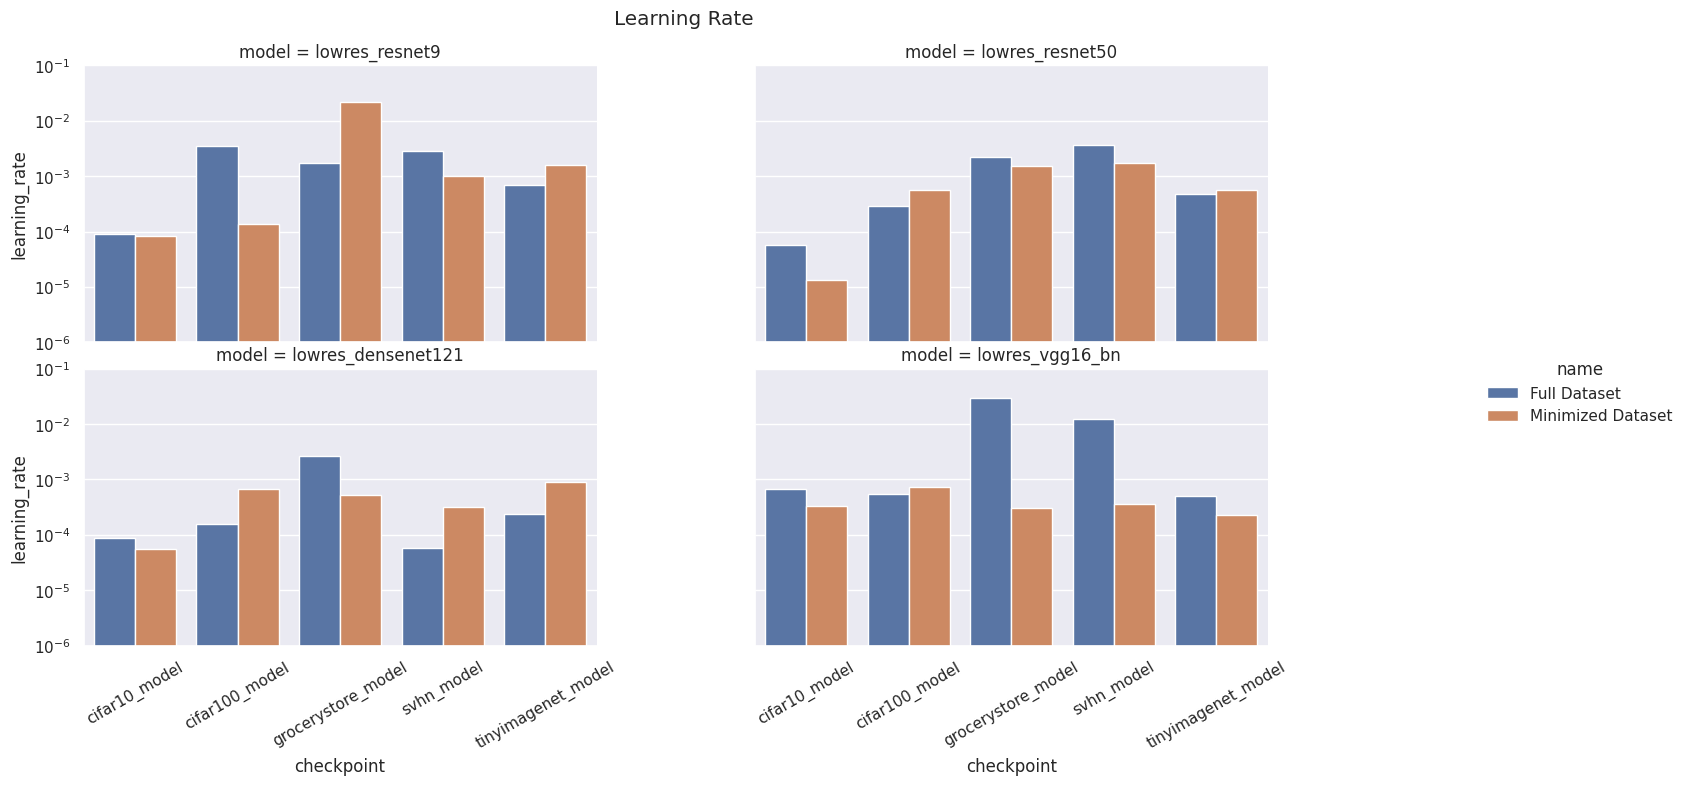

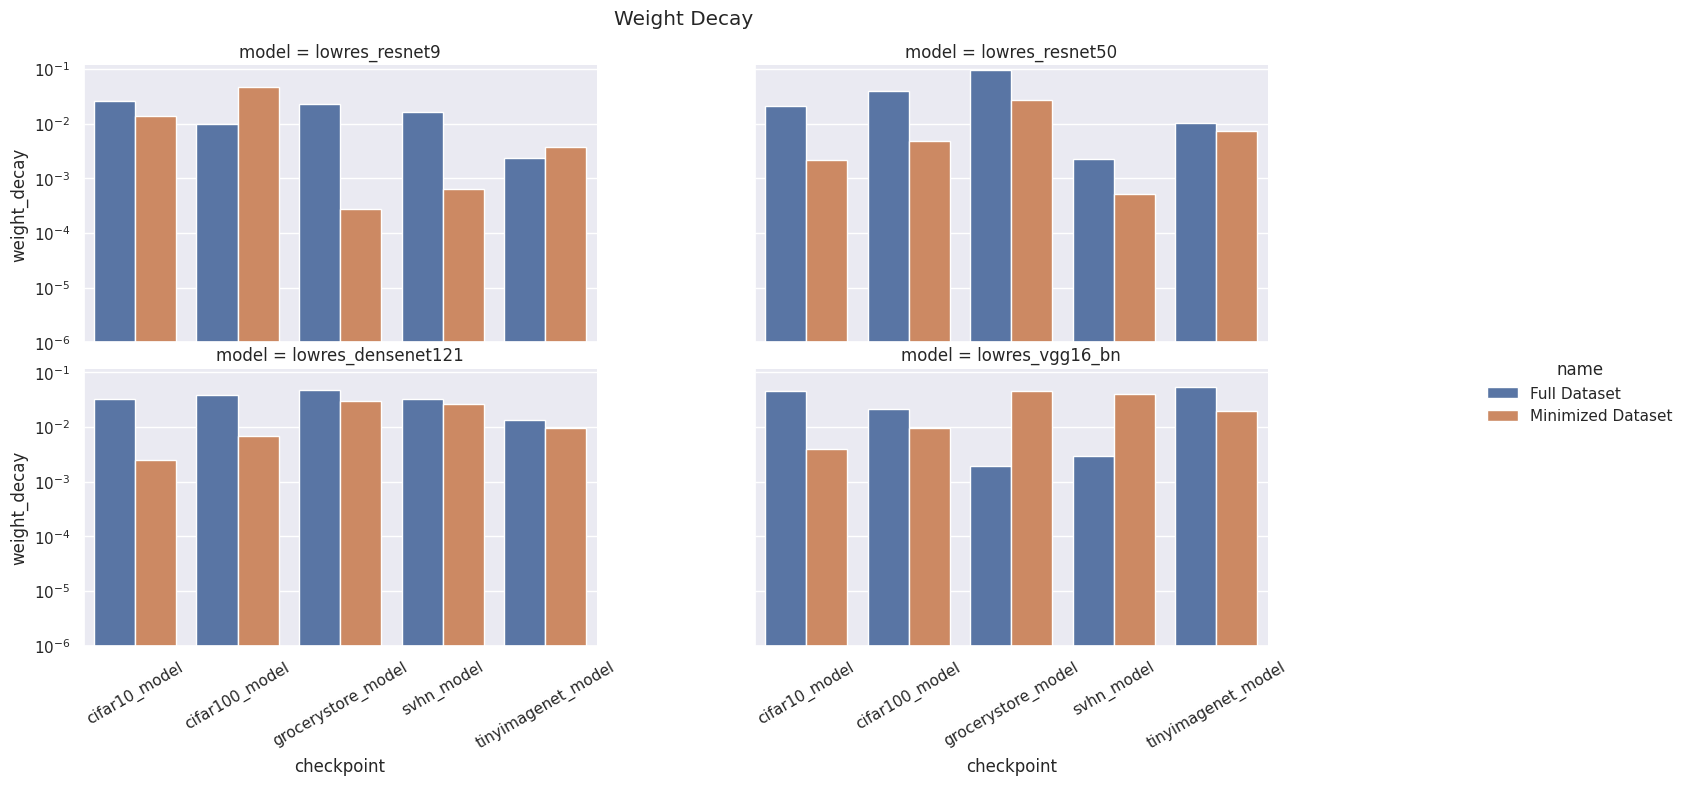

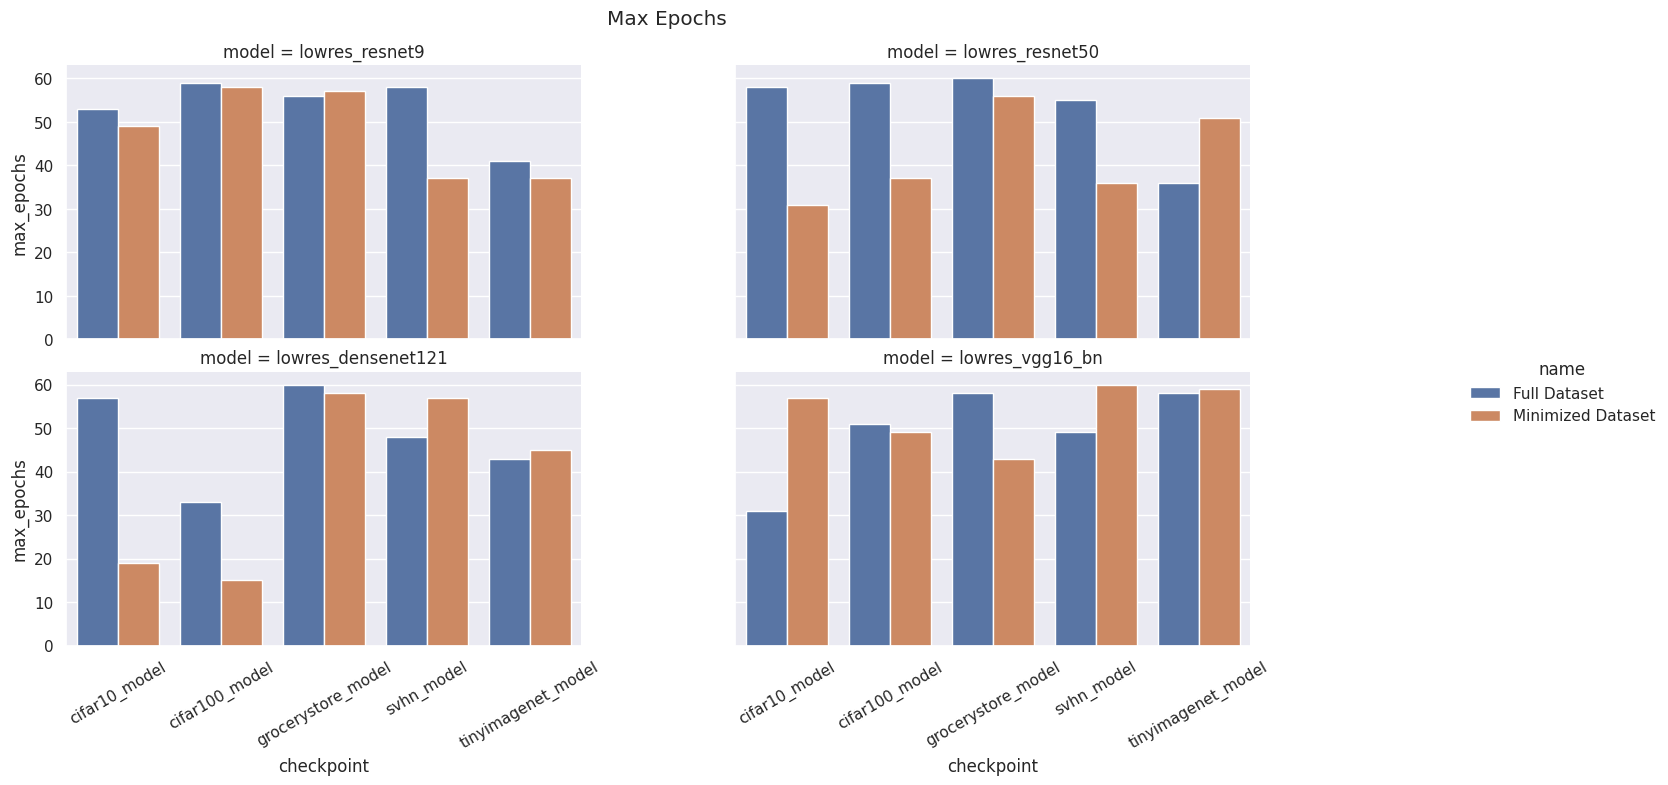

In [27]:
checkpoint_names=[
    "cifar10_model",
    "cifar100_model",
    "grocerystore_model",
    "svhn_model",
    "tinyimagenet_model"
]

plot_hyperparameters_difference(
    checkpoints=[7,8,9,10,11],
    compare_checkpoints=[1,2,3,4,5],
    output_path="../../../output_sweep/",
    dataset="cifar10",
    models=['lowres_resnet9','lowres_resnet50','lowres_densenet121','lowres_vgg16_bn'],
    checkpoint_names=checkpoint_names)

### Hyperparameter Difference Plots
- Pretraining Full Dataset
- Finetuning Small Dataset
- Difference of Hyperparameters ("Small Dataset Finetuning Sweep Hyperparameters" to "Full Dataset Finetuning Sweep Hyperparameters" to "Small Dataset Default Parameters Hyperparameters")

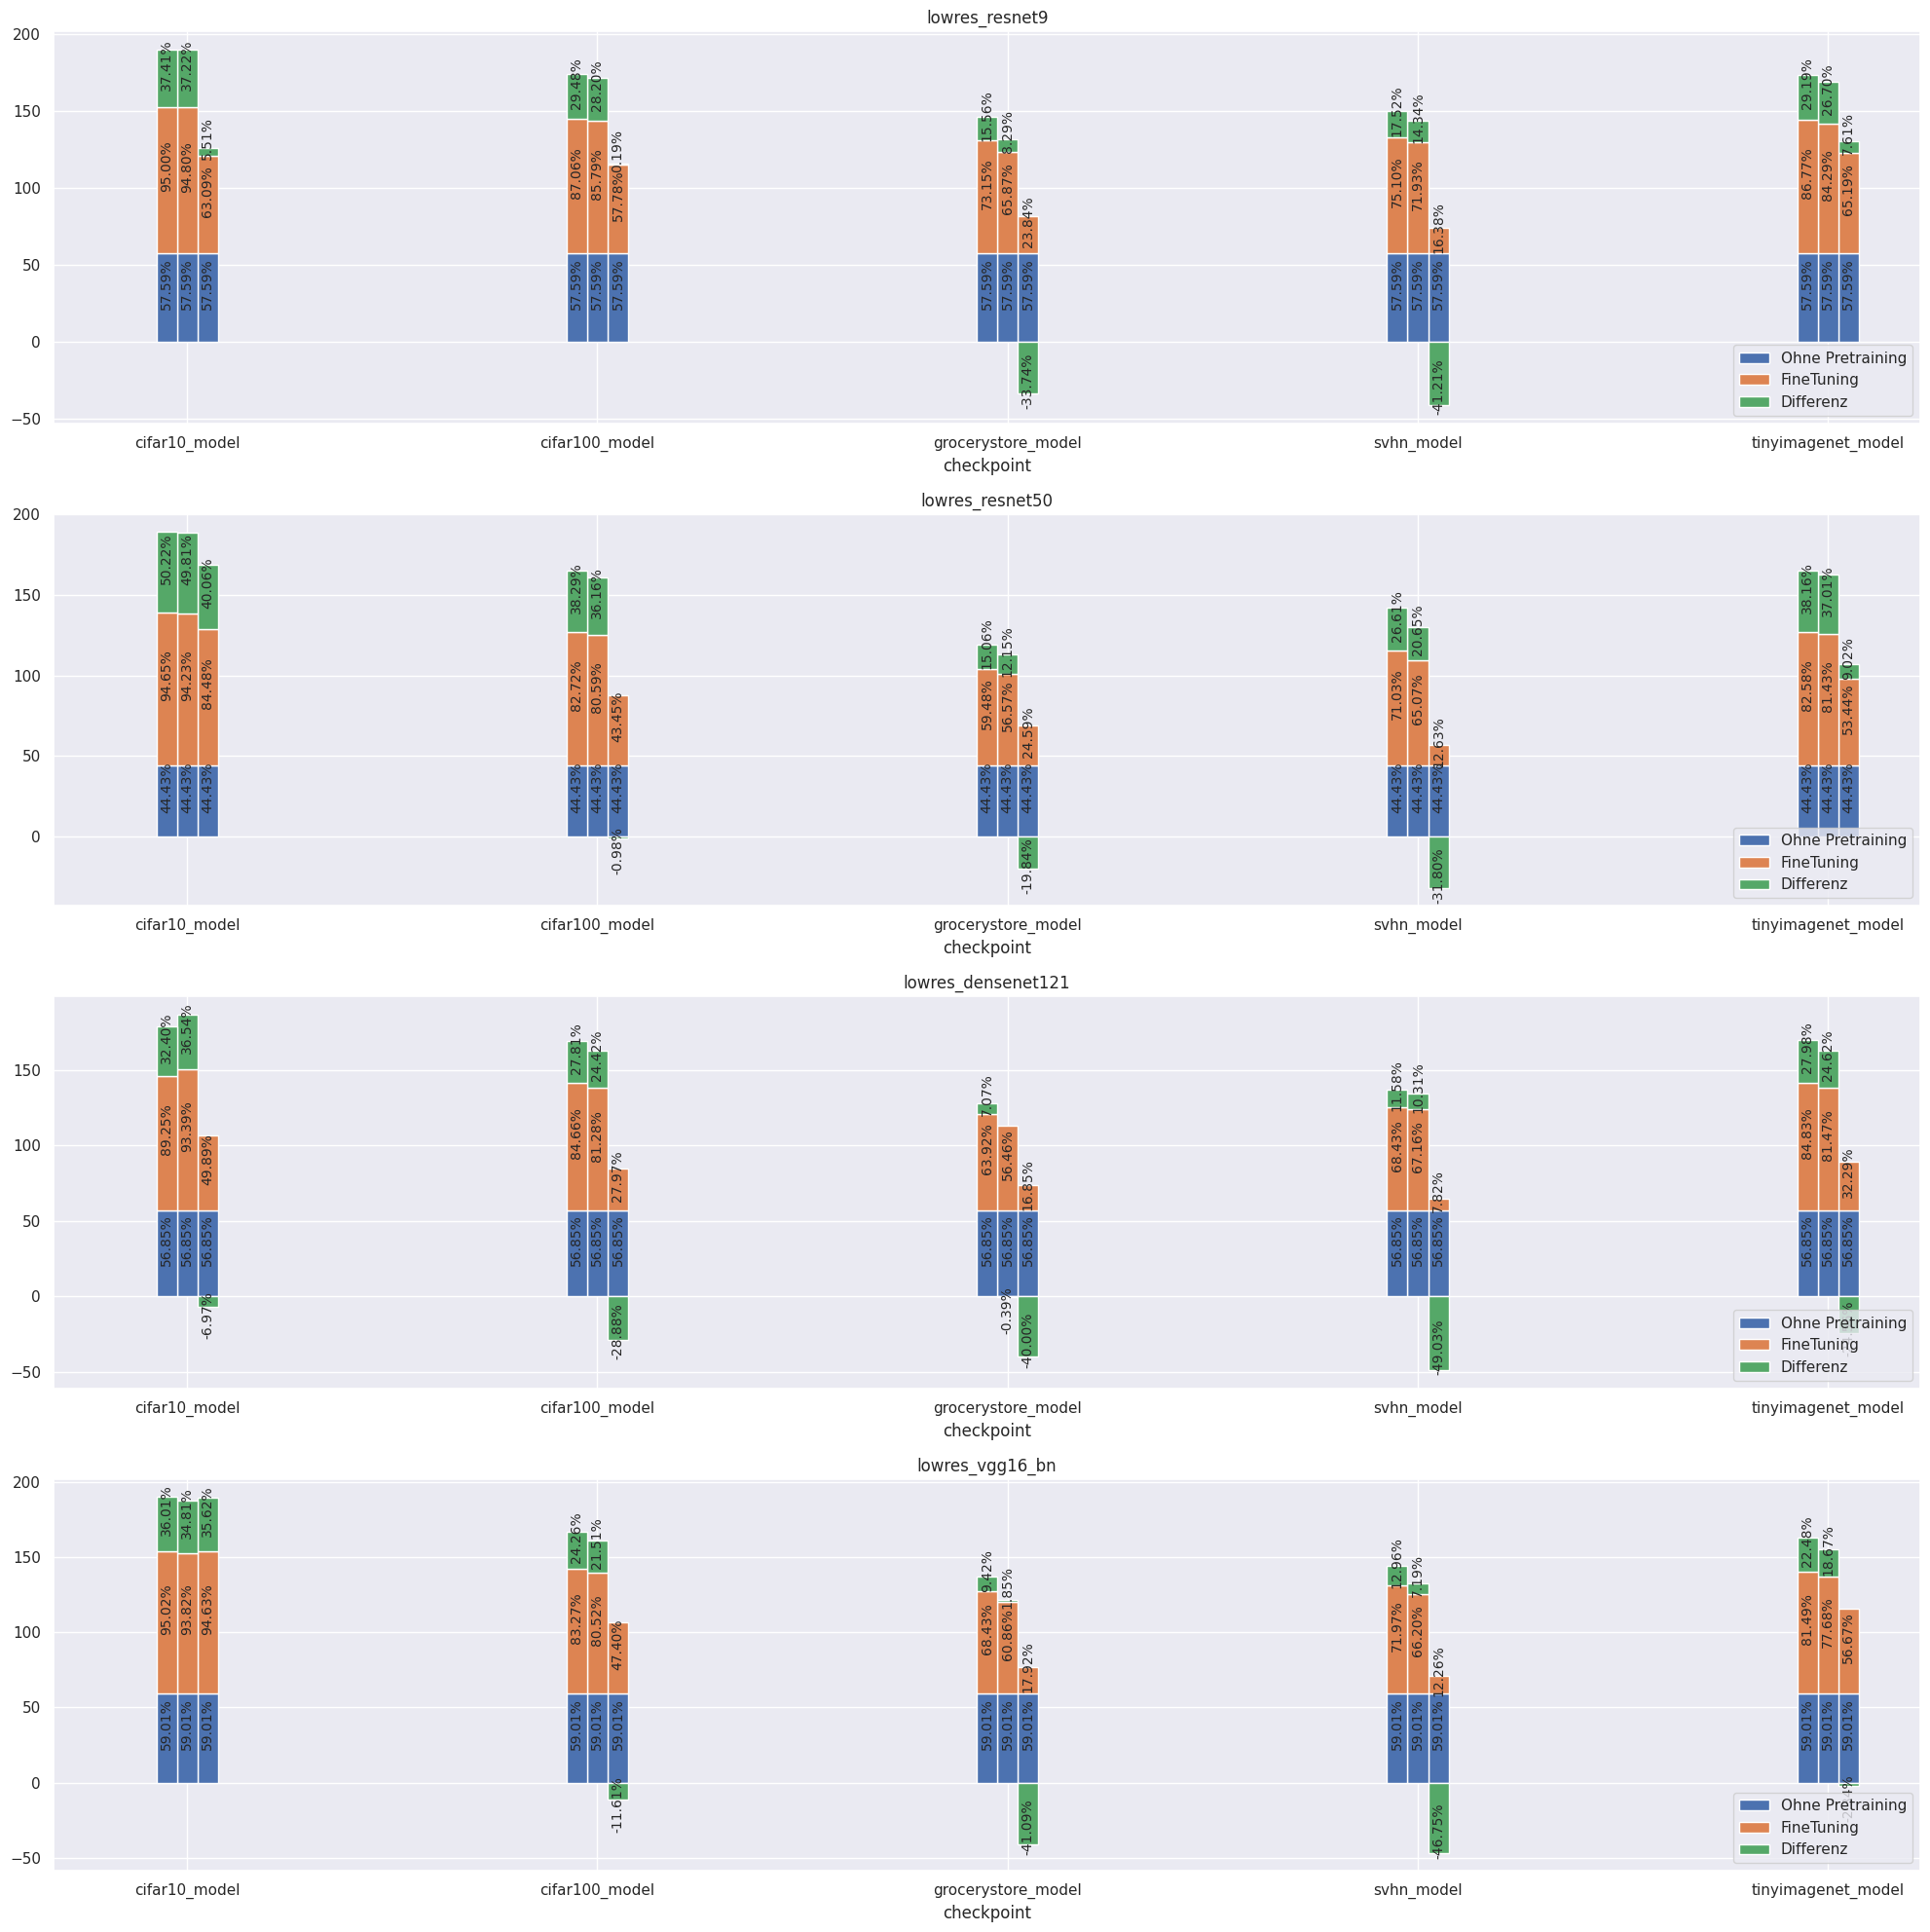

In [28]:
fig=bar_plot(runs)

## Variance and Mean of multiple Experiments

### Experiment 1

- Pretraining on Full Dataset
- Finetuning on Minimized Dataset with best Parameters

In [68]:
dataset="cifar10"
runs=[]
for c in range(0,50,5):
    checkpoint_range=list(range(c,c+5))
    checkpoints={
        dataset:{
            "lowres_resnet9": checkpoint_range,
            "lowres_resnet50": checkpoint_range,
            "lowres_densenet121": checkpoint_range,
            "lowres_vgg16_bn": checkpoint_range
        }            
    }
    run=Run(checkpoints,{},"../../../output_tuning_compare/",columns=checkpoint_names,name=f"Run {int(c/5)}")
    run.run_df['name']=run.name
    runs.append(run.run_df)

In [69]:
df=pd.concat(runs)

In [70]:
df.set_index("name")

,model,dataset,checkpoint,type,accuracy,loss,learning_rate,max_epochs,weight_decay,optimizer
name,,,,,,,,,,
Run 0,lowres_resnet9,cifar10,cifar10_model,MinimizedDataset,94.995956,0.555813,0.000089,53,0.025784,sgd
Run 0,lowres_resnet9,cifar10,cifar100_model,MinimizedDataset,85.223602,0.451811,0.003469,59,0.009676,sgd
Run 0,lowres_resnet9,cifar10,grocerystore_model,MinimizedDataset,70.231682,1.399002,0.001726,56,0.022700,adamw
Run 0,lowres_resnet9,cifar10,svhn_model,MinimizedDataset,75.000000,0.771688,0.002828,58,0.016195,sgd
Run 0,lowres_resnet9,cifar10,tinyimagenet_model,MinimizedDataset,83.640892,0.538306,0.000688,41,0.002369,adagrad
...,...,...,...,...,...,...,...,...,...,...
Run 9,lowres_vgg16_bn,cifar10,cifar10_model,MinimizedDataset,94.645744,1.179744,0.000664,31,0.045106,sgd
Run 9,lowres_vgg16_bn,cifar10,cifar100_model,MinimizedDataset,81.256737,0.722690,0.000551,51,0.021315,adagrad
Run 9,lowres_vgg16_bn,cifar10,grocerystore_model,MinimizedDataset,67.982224,1.267578,0.029694,58,0.001924,sgd


#### Total

In [71]:
df[['accuracy','loss']].var()

accuracy    120.501196
loss          0.155811
dtype: float64

In [72]:
df[['accuracy','loss']].mean()

accuracy    78.210904
loss         0.975879
dtype: float64

<AxesSubplot:xlabel='model,checkpoint'>

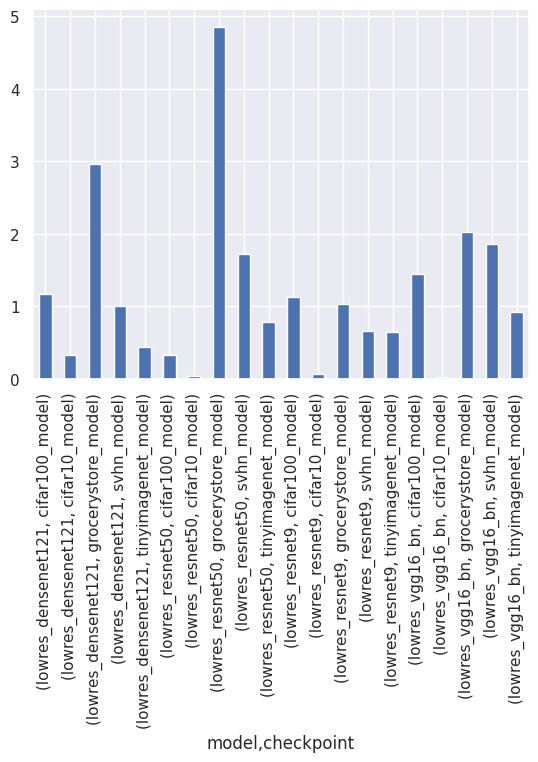

In [73]:
df[["model",'checkpoint','accuracy','loss']].groupby(["model",'checkpoint']).var()['accuracy'].plot.bar()

<AxesSubplot:xlabel='model,checkpoint'>

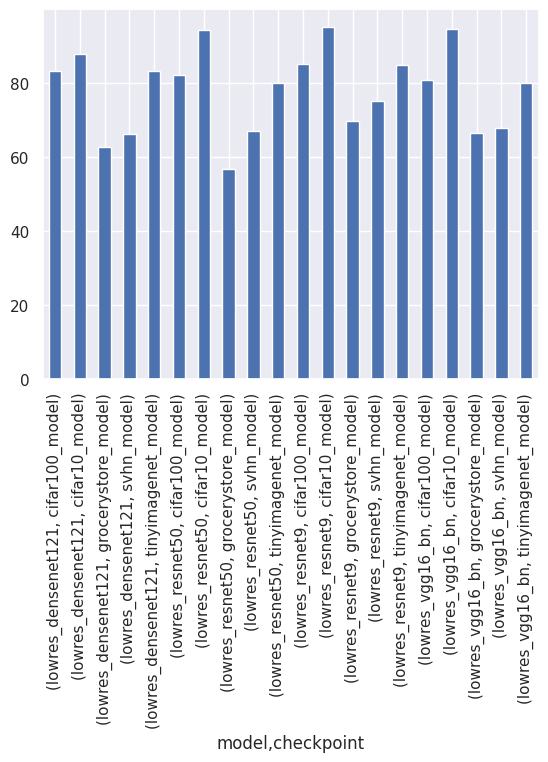

In [74]:
df[["model",'checkpoint','accuracy','loss']].groupby(["model",'checkpoint']).mean()['accuracy'].plot.bar()

<AxesSubplot:xlabel='model,checkpoint'>

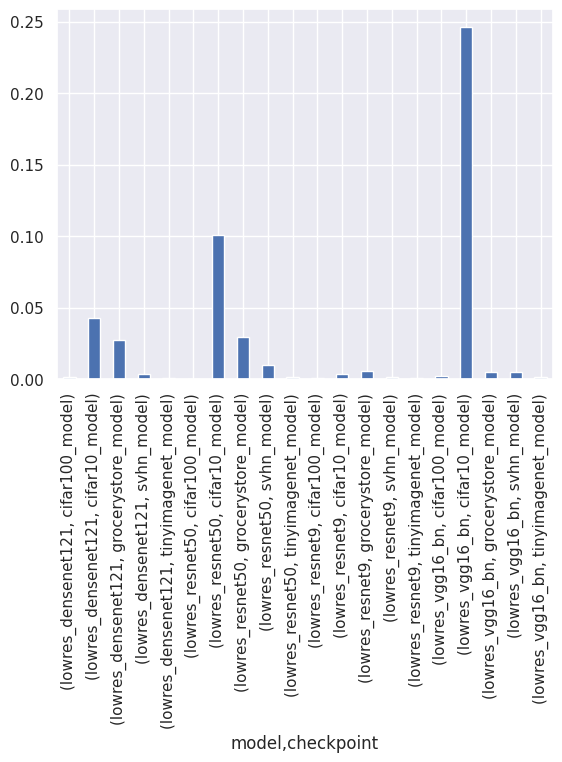

In [75]:
df[["model",'checkpoint','accuracy','loss']].groupby(["model",'checkpoint']).var()['loss'].plot.bar()

<AxesSubplot:xlabel='model,checkpoint'>

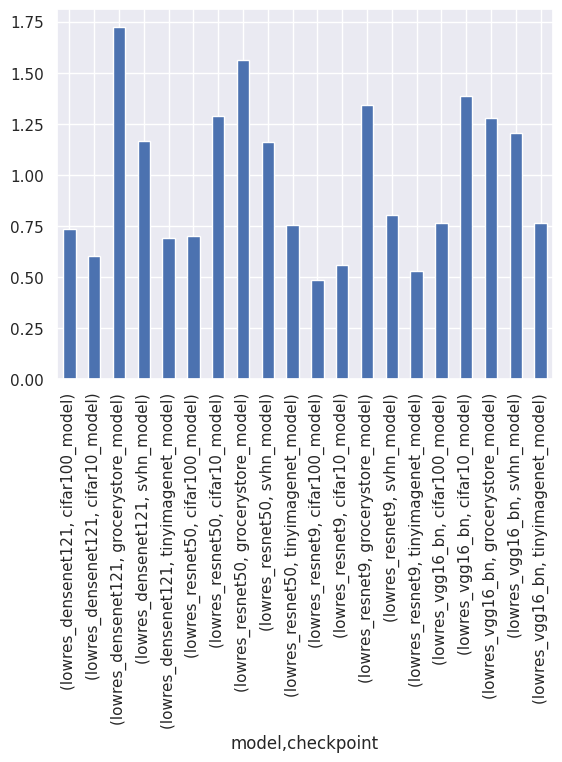

In [76]:
df[["model",'checkpoint','accuracy','loss']].groupby(["model",'checkpoint']).mean()['loss'].plot.bar()

### Experiment 2

In [77]:
dataset="cifar10"
runs=[]
for c in range(0,100,5):
    checkpoint_range=list(range(c,c+5))
    checkpoints={
        dataset:{
            "lowres_resnet9": checkpoint_range,
            "lowres_resnet50": checkpoint_range,
            "lowres_densenet121": checkpoint_range,
            "lowres_vgg16_bn": checkpoint_range
        }            
    }
    run=Run(checkpoints,{},os.path.join("../../../finetuning_multiple_runs","output"),columns=checkpoint_names,name=f"Run {int(c/5)}")
    run.run_df['name']=run.name
    runs.append(run)

In [91]:
run_all_df=pd.concat([run.run_df[['checkpoint','model','loss']].set_index(['checkpoint','model']).sort_values(by=['checkpoint','model']) for run in runs],axis=1)
# p_df=run_all_df[run_all_df['type']=='MinimizedDataset'][['checkpoint','model','accuracy','loss']].set_index(['checkpoint','model']).sort_values(by=['checkpoint','model'])
# p_df
run_all_df.to_csv("../../../cache/multiple_runs_all_loss.csv")

In [78]:
df=pd.concat([run.run_df for run in runs])

In [79]:
df.set_index("name")

,model,dataset,checkpoint,type,accuracy,loss,learning_rate,max_epochs,weight_decay,optimizer
name,,,,,,,,,,
Run 0,lowres_resnet9,cifar10,cifar10_model,MinimizedDataset,93.938576,0.476646,0.000089,53,0.025784,sgd
Run 0,lowres_resnet9,cifar10,cifar100_model,MinimizedDataset,82.172684,0.565347,0.003469,59,0.009676,sgd
Run 0,lowres_resnet9,cifar10,grocerystore_model,MinimizedDataset,69.288795,1.218442,0.001726,56,0.022700,adamw
Run 0,lowres_resnet9,cifar10,svhn_model,MinimizedDataset,72.966057,0.819482,0.002828,58,0.016195,sgd
Run 0,lowres_resnet9,cifar10,tinyimagenet_model,MinimizedDataset,82.428612,0.591299,0.000688,41,0.002369,adagrad
...,...,...,...,...,...,...,...,...,...,...
Run 19,lowres_vgg16_bn,cifar10,cifar10_model,MinimizedDataset,94.760239,1.963360,0.000664,31,0.045106,sgd
Run 19,lowres_vgg16_bn,cifar10,cifar100_model,MinimizedDataset,79.808731,0.795493,0.000551,51,0.021315,adagrad
Run 19,lowres_vgg16_bn,cifar10,grocerystore_model,MinimizedDataset,67.315460,1.277669,0.029694,58,0.001924,sgd


### Total

In [41]:
df[['accuracy','loss']].var()

accuracy    103.952132
loss          0.158326
dtype: float64

In [42]:
df[['accuracy','loss']].mean()

accuracy    77.930344
loss         1.027679
dtype: float64

Text(0, 0.5, 'Variance (Accuracy)')

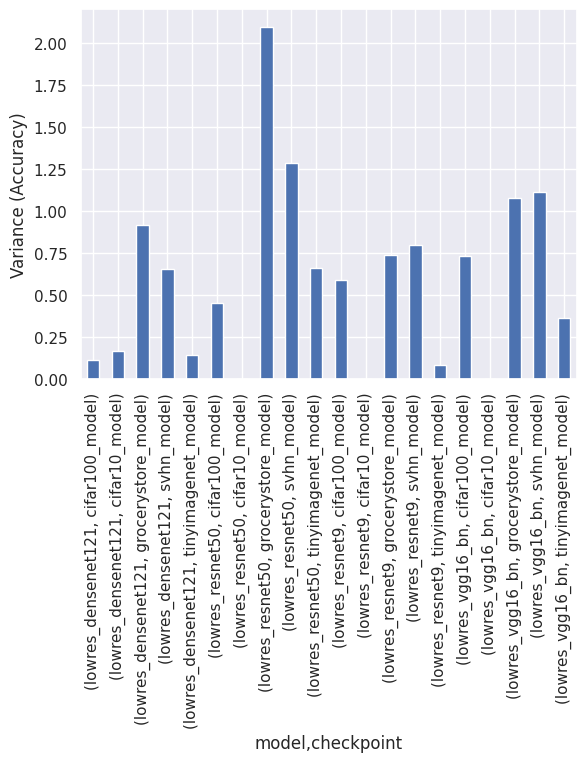

In [43]:
ax=df[["model",'checkpoint','accuracy','loss']].groupby(["model",'checkpoint']).var()['accuracy'].plot.bar()
ax.set_ylabel("Variance (Accuracy)")

Text(0, 0.5, 'Mean (Accuracy)')

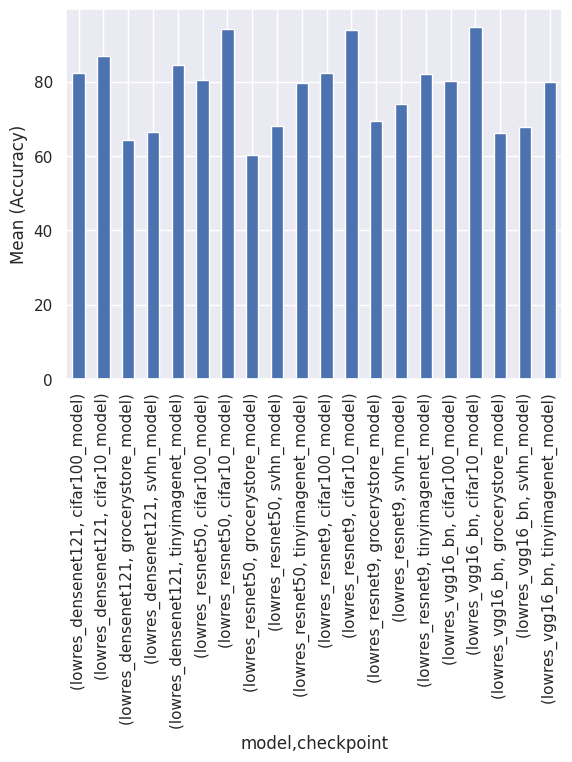

In [44]:
ax=df[["model",'checkpoint','accuracy','loss']].groupby(["model",'checkpoint']).mean()['accuracy'].plot.bar()
ax.set_ylabel("Mean (Accuracy)")

<AxesSubplot:xlabel='model,checkpoint'>

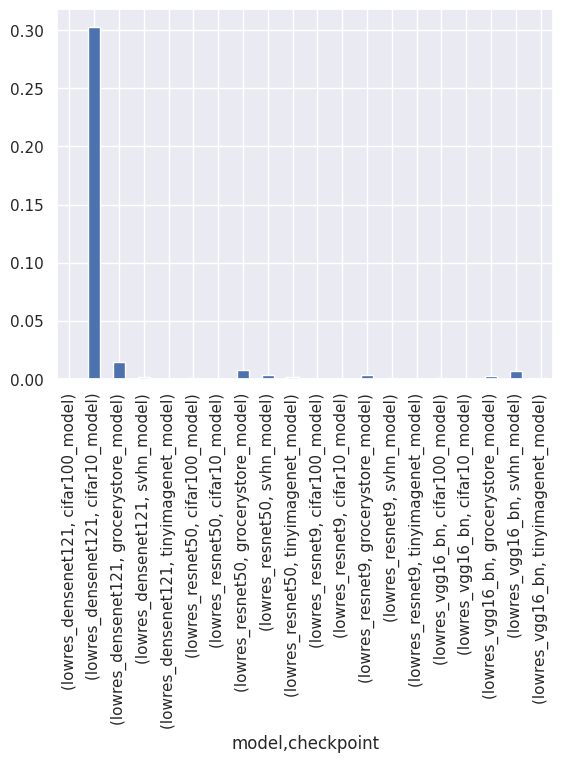

In [45]:
df[["model",'checkpoint','accuracy','loss']].groupby(["model",'checkpoint']).var()['loss'].plot.bar()

<AxesSubplot:xlabel='model,checkpoint'>

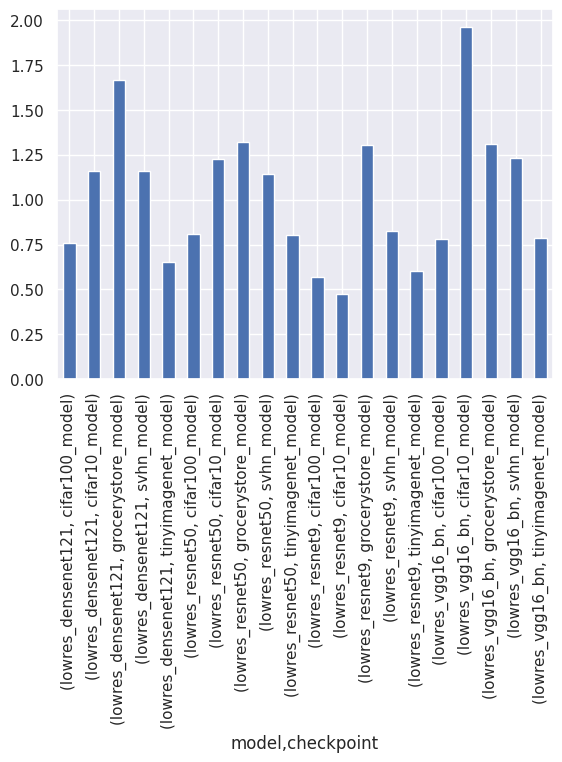

In [46]:
df[["model",'checkpoint','accuracy','loss']].groupby(["model",'checkpoint']).mean()['loss'].plot.bar()

### Experiment 3

In [47]:
dataset="cifar10"
runs=[]
for c in range(0,100,5):
    checkpoint_range=list(range(c,c+5))
    checkpoints={
        dataset:{
            "lowres_resnet9": checkpoint_range,
            "lowres_resnet50": checkpoint_range,
            "lowres_densenet121": checkpoint_range,
            "lowres_vgg16_bn": checkpoint_range
        }            
    }
    run=Run(checkpoints,{},os.path.join("../../../finetuning_multiple_runs","output_freeze_not_tuned"),columns=checkpoint_names,name=f"Run {int(c/5)}")
    run.run_df['name']=run.name
    runs.append(run.run_df)

In [48]:
df=pd.concat(runs)

In [49]:
df.set_index("name")

,model,dataset,checkpoint,type,accuracy,loss,learning_rate,max_epochs,weight_decay,optimizer
name,,,,,,,,,,
Run 0,lowres_resnet9,cifar10,cifar10_model,MinimizedDataset,94.955551,0.931159,0.000089,53,0.025784,sgd
Run 0,lowres_resnet9,cifar10,cifar100_model,MinimizedDataset,76.091057,0.704128,0.003469,59,0.009676,sgd
Run 0,lowres_resnet9,cifar10,grocerystore_model,MinimizedDataset,43.743263,1.532661,0.001726,56,0.022700,adamw
Run 0,lowres_resnet9,cifar10,svhn_model,MinimizedDataset,55.980602,1.250845,0.002828,58,0.016195,sgd
Run 0,lowres_resnet9,cifar10,tinyimagenet_model,MinimizedDataset,73.592407,0.848907,0.000688,41,0.002369,adagrad
...,...,...,...,...,...,...,...,...,...,...
Run 19,lowres_vgg16_bn,cifar10,cifar10_model,MinimizedDataset,63.894127,0.974360,0.000551,51,0.021315,adagrad
Run 19,lowres_vgg16_bn,cifar10,cifar100_model,MinimizedDataset,44.288795,1.574436,0.029694,58,0.001924,sgd
Run 19,lowres_vgg16_bn,cifar10,grocerystore_model,MinimizedDataset,56.175915,1.238245,0.012423,49,0.002879,sgd


### Total

In [50]:
df[['accuracy','loss']].var()

accuracy    295.98677
loss          0.19064
dtype: float64

In [51]:
df[['accuracy','loss']].mean()

accuracy    67.625977
loss         1.239680
dtype: float64

<AxesSubplot:xlabel='model,checkpoint'>

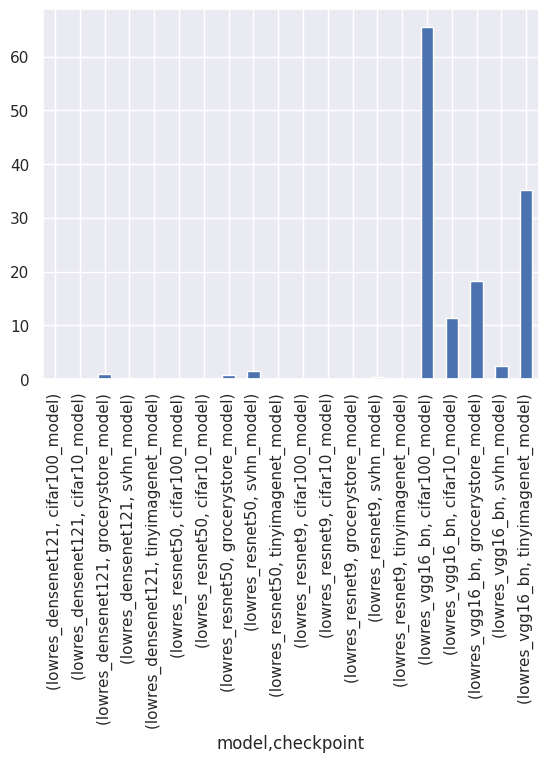

In [52]:
df[["model",'checkpoint','accuracy','loss']].groupby(["model",'checkpoint']).var()['accuracy'].plot.bar()

<AxesSubplot:xlabel='model,checkpoint'>

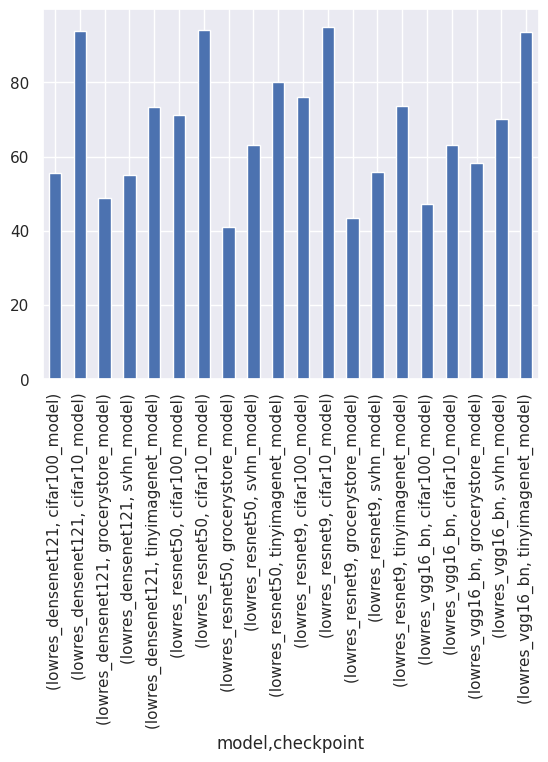

In [53]:
df[["model",'checkpoint','accuracy','loss']].groupby(["model",'checkpoint']).mean()['accuracy'].plot.bar()

<AxesSubplot:xlabel='model,checkpoint'>

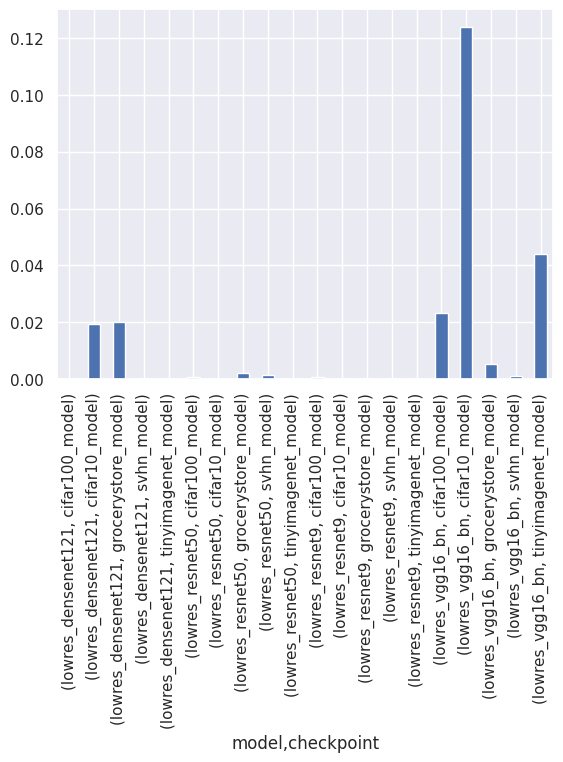

In [54]:
df[["model",'checkpoint','accuracy','loss']].groupby(["model",'checkpoint']).var()['loss'].plot.bar()

<AxesSubplot:xlabel='model,checkpoint'>

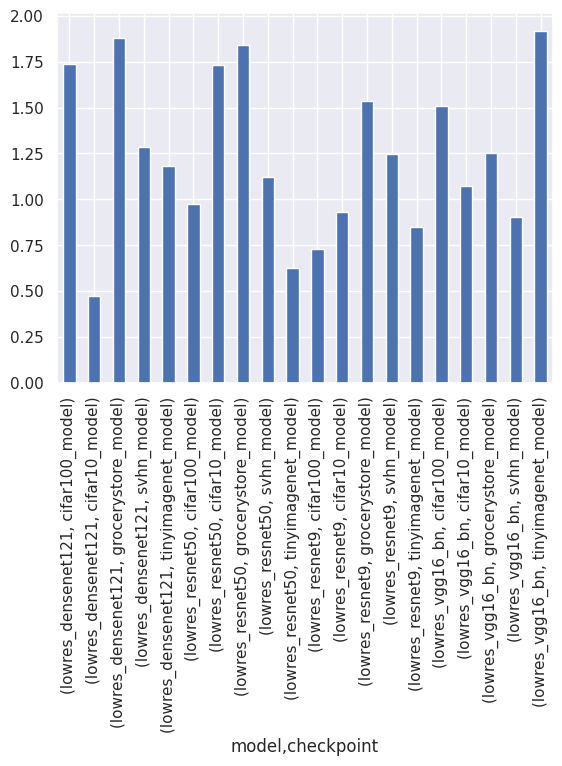

In [55]:
df[["model",'checkpoint','accuracy','loss']].groupby(["model",'checkpoint']).mean()['loss'].plot.bar()

### Experiment 4

In [92]:
dataset="cifar10"
runs=[]
for c in range(0,100,5):
    checkpoint_range=list(range(c,c+5))
    checkpoints={
        dataset:{
            "lowres_resnet9": checkpoint_range,
            "lowres_resnet50": checkpoint_range,
            "lowres_densenet121": checkpoint_range,
            "lowres_vgg16_bn": checkpoint_range
        }            
    }
    run=Run(checkpoints,{},os.path.join("../../../finetuning_multiple_runs","output_freeze"),columns=checkpoint_names,name=f"Run {int(c/5)}")
    run.run_df['name']=run.name
    runs.append(run)

In [96]:
run_all_df=pd.concat([run.run_df[['checkpoint','model','loss']].set_index(['checkpoint','model']).sort_values(by=['checkpoint','model']) for run in runs],axis=1)
# p_df=run_all_df[run_all_df['type']=='MinimizedDataset'][['checkpoint','model','accuracy','loss']].set_index(['checkpoint','model']).sort_values(by=['checkpoint','model'])
# p_df
run_all_df.to_csv("../../../cache/multiple_runs_freeze_all_loss.csv")

In [94]:
df=pd.concat([run.run_df for run in runs])

In [95]:
df.set_index("name")

,model,dataset,checkpoint,type,accuracy,loss,learning_rate,max_epochs,weight_decay,optimizer
name,,,,,,,,,,
Run 0,lowres_resnet9,cifar10,cifar10_model,MinimizedDataset,94.955551,0.267458,0.004004,28,0.042768,adagrad
Run 0,lowres_resnet9,cifar10,cifar100_model,MinimizedDataset,78.340515,0.688986,0.008204,44,0.000683,adagrad
Run 0,lowres_resnet9,cifar10,grocerystore_model,MinimizedDataset,47.885239,1.469468,0.011721,60,0.020707,adamw
Run 0,lowres_resnet9,cifar10,svhn_model,MinimizedDataset,57.152477,1.198688,0.010389,60,0.005858,sgd
Run 0,lowres_resnet9,cifar10,tinyimagenet_model,MinimizedDataset,79.963631,0.610663,0.006450,40,0.011538,adagrad
...,...,...,...,...,...,...,...,...,...,...
Run 19,lowres_vgg16_bn,cifar10,cifar10_model,MinimizedDataset,94.544724,0.267399,0.002276,47,0.006769,adagrad
Run 19,lowres_vgg16_bn,cifar10,cifar100_model,MinimizedDataset,72.258888,0.858116,0.006253,31,0.040620,sgd
Run 19,lowres_vgg16_bn,cifar10,grocerystore_model,MinimizedDataset,38.543911,1.640026,0.049461,46,0.012637,sgd


### Total

In [59]:
df[['accuracy','loss']].var()

accuracy    285.962884
loss          0.202300
dtype: float64

In [60]:
df[['accuracy','loss']].mean()

accuracy    71.254378
loss         1.034906
dtype: float64

Text(0, 0.5, 'Variance (Accuracy)')

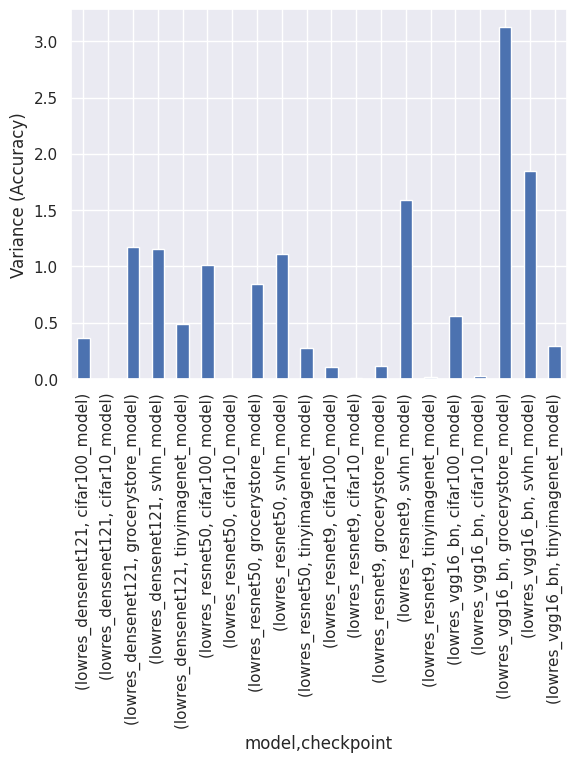

In [61]:
ax=df[["model",'checkpoint','accuracy','loss']].groupby(["model",'checkpoint']).var()['accuracy'].plot.bar()
ax.set_ylabel("Variance (Accuracy)")

<AxesSubplot:xlabel='model,checkpoint'>

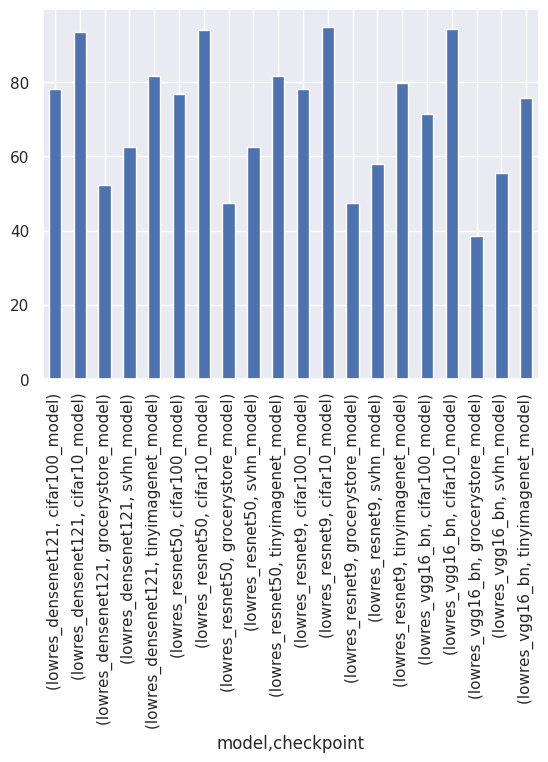

In [62]:
df[["model",'checkpoint','accuracy','loss']].groupby(["model",'checkpoint']).mean()['accuracy'].plot.bar()

<AxesSubplot:xlabel='model,checkpoint'>

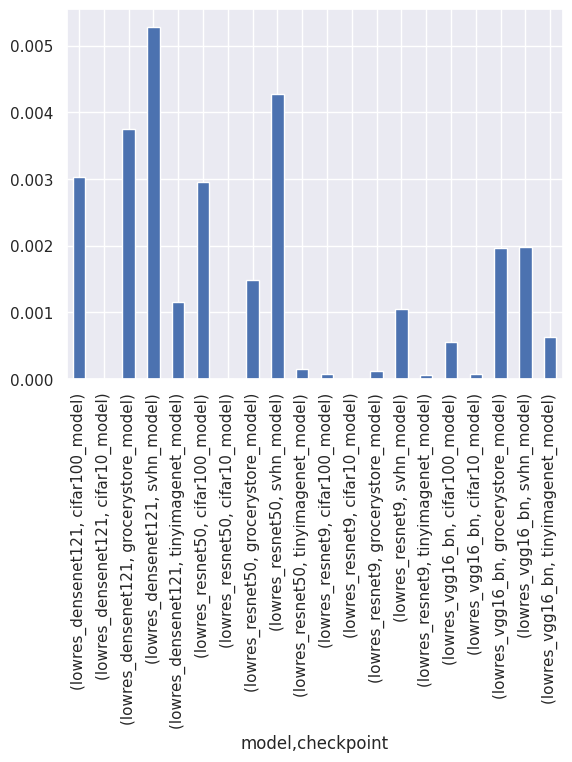

In [63]:
df[["model",'checkpoint','accuracy','loss']].groupby(["model",'checkpoint']).var()['loss'].plot.bar()

<AxesSubplot:xlabel='model,checkpoint'>

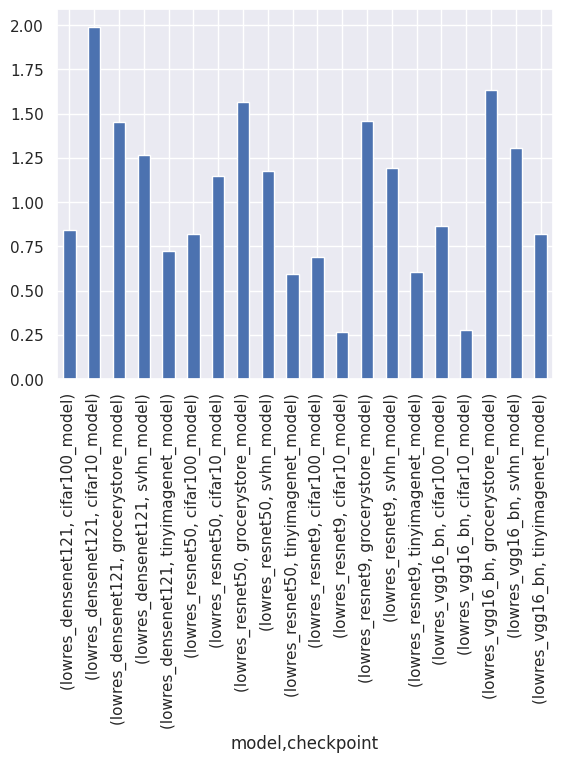

In [64]:
df[["model",'checkpoint','accuracy','loss']].groupby(["model",'checkpoint']).mean()['loss'].plot.bar()

### Comparsion

In [65]:
run_2_sample_checkpoints={
    "cifar10": {
        "lowres_resnet9":[0,1,2,3,4],
        "lowres_resnet50":[0,1,2,3,4],
        "lowres_densenet121":[0,1,2,3,4],
        "lowres_vgg16_bn":[0,1,2,3,4],
               }    
}
run_2_sample_compare_checkpoints={
    "cifar10": {
        "lowres_resnet9":[100,100,100,100,100],
        "lowres_resnet50":[100,100,100,100,100],
        "lowres_densenet121":[100,100,100,100,100],
        "lowres_vgg16_bn":[100,100,100,100,100],
               } 
}

run_4_sample_checkpoints={
    "cifar10": {
        "lowres_resnet9":[0,1,2,3,4],
        "lowres_resnet50":[0,1,2,3,4],
        "lowres_densenet121":[0,1,2,3,4],
        "lowres_vgg16_bn":[0,1,2,3,4],
               }    
}
run_4_sample_compare_checkpoints={
    "cifar10": {
        "lowres_resnet9":[100,100,100,100,100],
        "lowres_resnet50":[100,100,100,100,100],
        "lowres_densenet121":[100,100,100,100,100],
        "lowres_vgg16_bn":[100,100,100,100,100],
               } 
}

In [66]:
runs=[
    Run(run_2_sample_checkpoints,run_2_sample_compare_checkpoints,"../../../finetuning_multiple_runs/output/",columns=checkpoint_names,name="Experiment 2 without Freeze"),
    Run(run_4_sample_checkpoints,run_4_sample_compare_checkpoints,"../../../finetuning_multiple_runs/output_freeze/",columns=checkpoint_names,name="Experiment 4 with Freeze")       
]

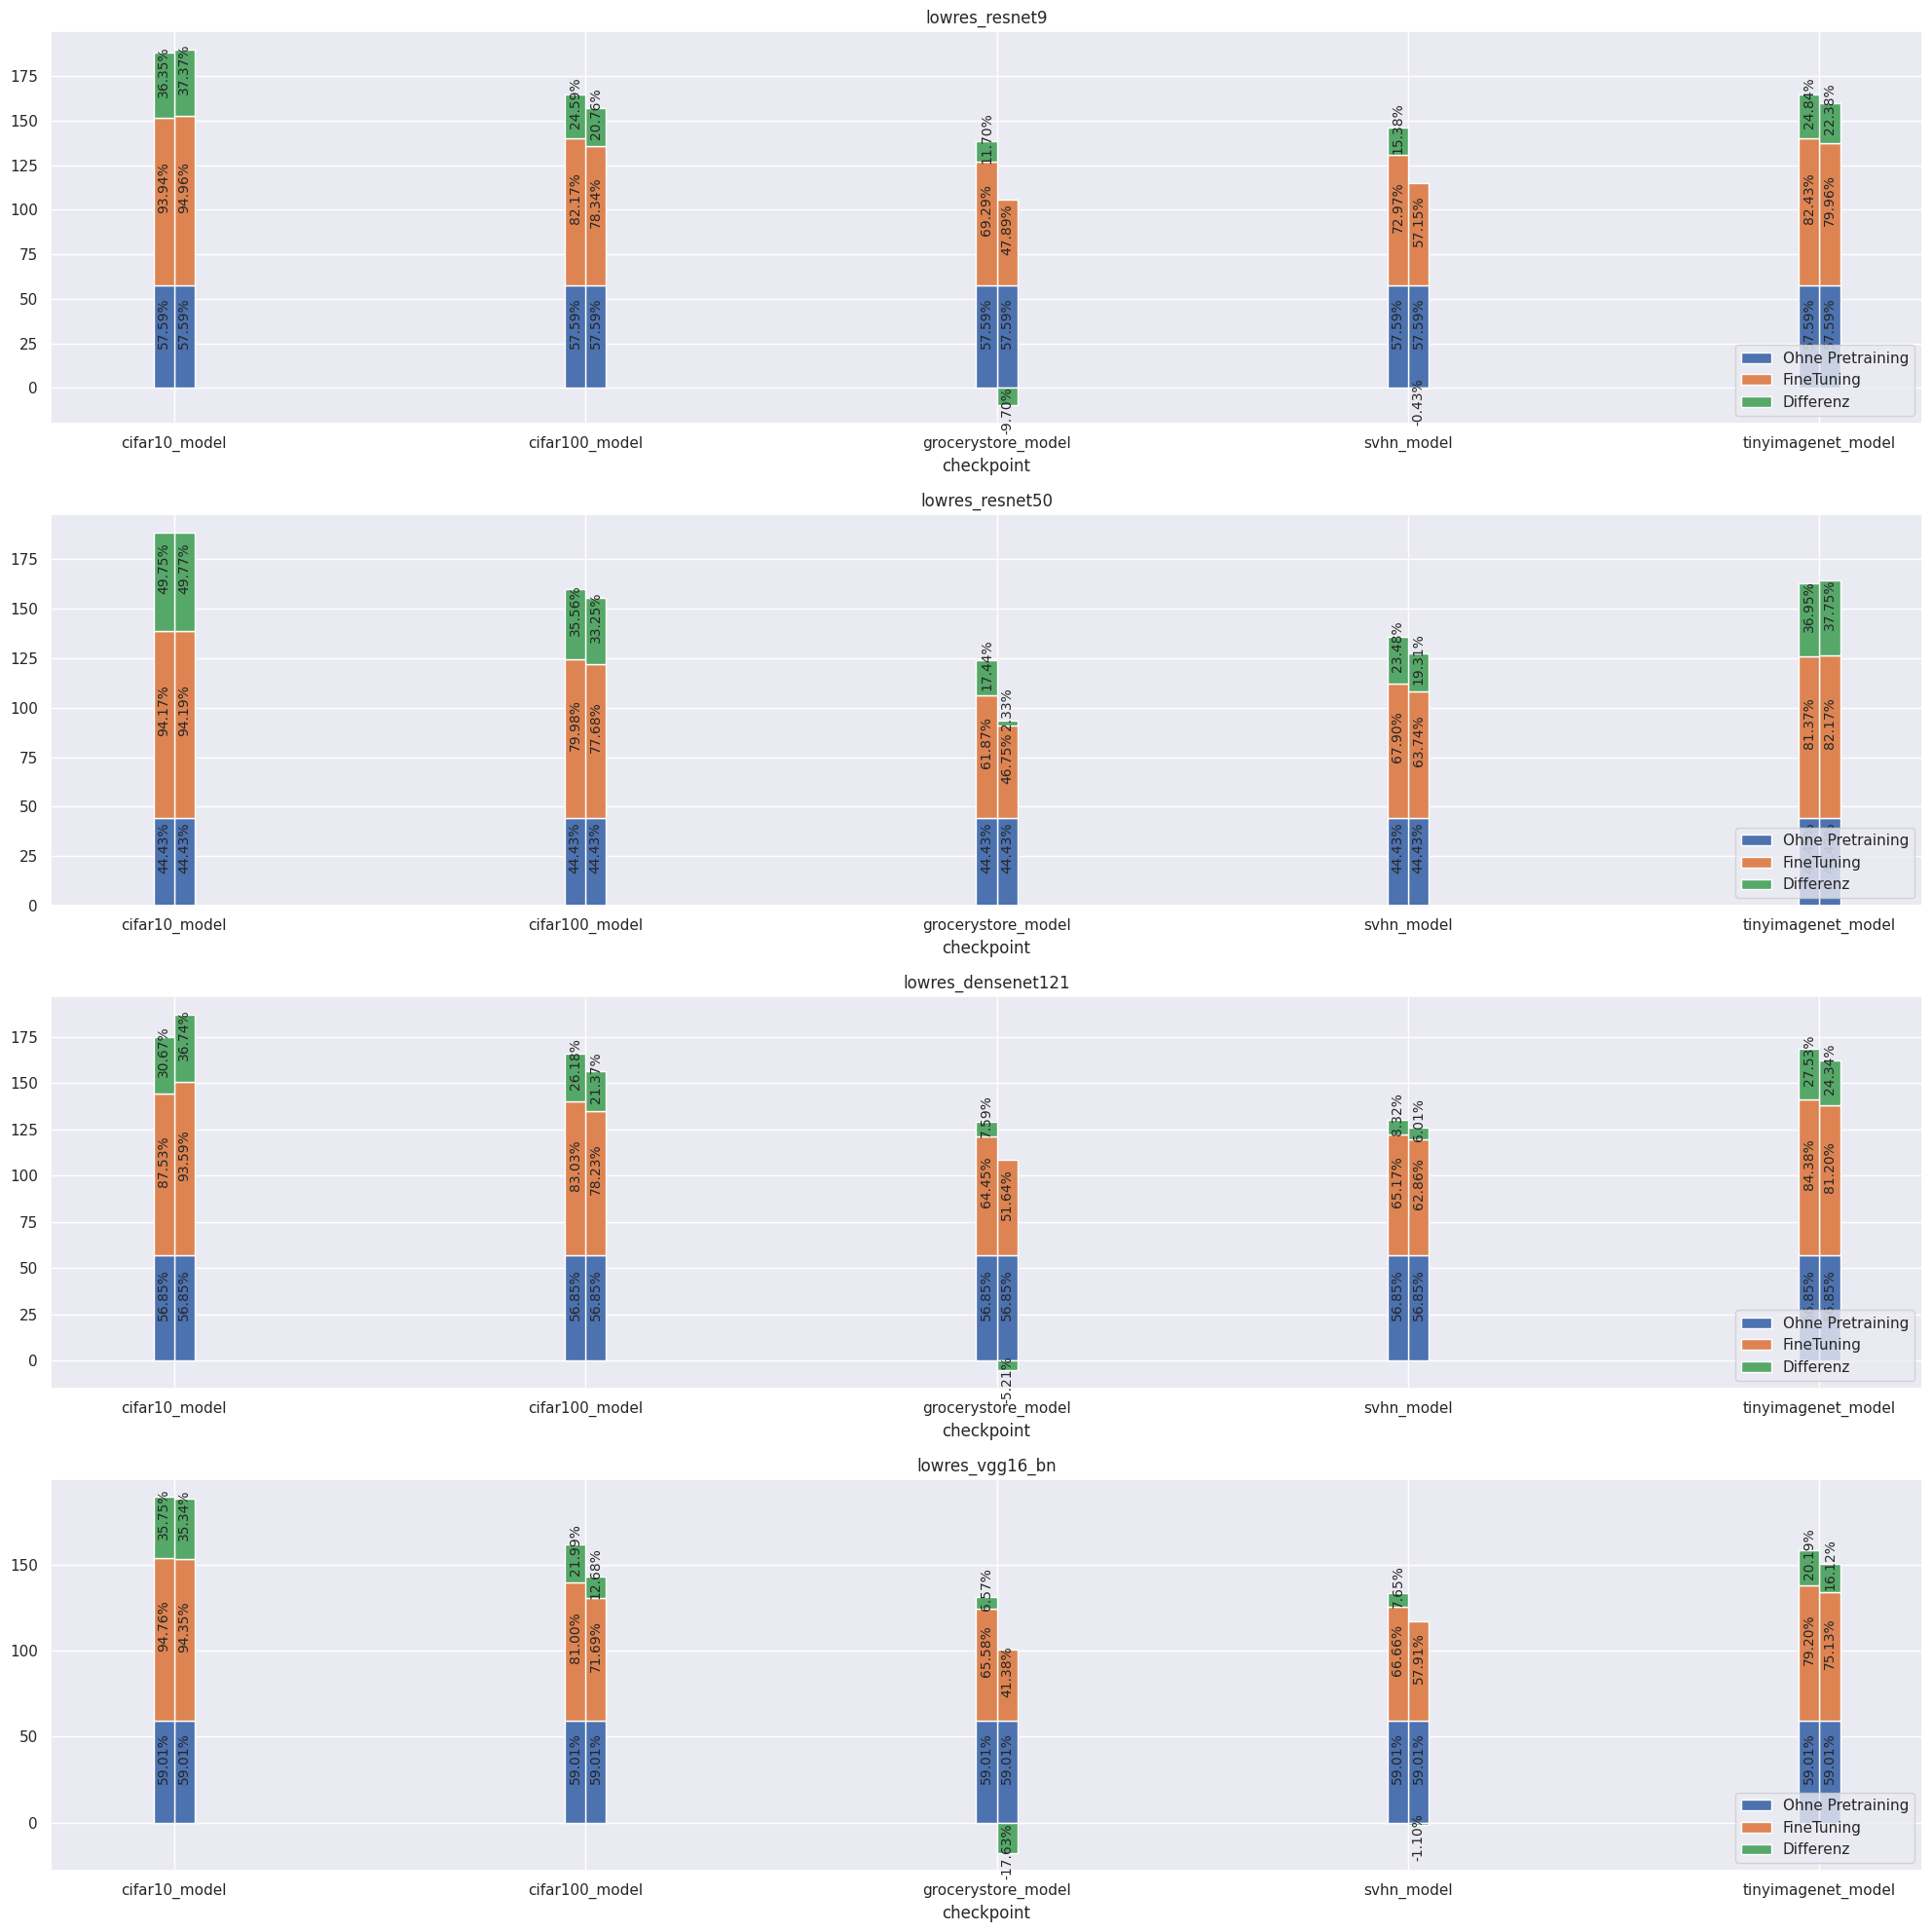

In [67]:
fig=bar_plot(runs)